# How Do Danes Drive?

### The project idea
The main idea behind our project is summarized in [this video](https://www.youtube.com/watch?v=LNPDZ1TbVPU&t=14s).

In Denmark:
- there are 2.5 million cars, about one in every two people, and 42600 trucks
- commuters spend 146 hours per week driving to work
- traffic delays cost Denmark 20 billion DKK every year

Driving has a considerable impact on the lives of Danes and on the Danish cities. Furthemore, investigating the driving behavior of a population might shed light on its underlying traits and on geographical differences.
Therefore, we would like to explore the driving behavior of Danes, visualize geographic patterns and explain the variation among municipalities. 

To do so, we will use two different data sets:
- a [traffic data set](https://www.opendata.dk/vejdirektoratet/stojdata-mastra) - containing data about traffic measurements performed in several Danish roads
- a [socioeconomic data set](http://noegletal.dk/noegletal/) - containing data about socioeconomic indicators in Danish municipalities


###  Index

I. Exploring the driving behavior (traffic data set)
   1. Data loading and cleaning
   2. Data manipulation
   3. Summary statistics and variable distribution
   4. Data exploration
    
II. Explaining the driving behavior
  1. Addressing our research questions
  2. The socioeconomic data set
  


# I. Exploring the driving behavior (traffic data set)
## 1. Data loading and cleaning


### 1.A Importing packages and defining functions

##### Import packages

In [1]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from folium import plugins
from folium.plugins import HeatMap
import folium
from scipy import stats
import branca
from sklearn.neighbors import KNeighborsRegressor
np.warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 30)

##### Define functions

In [2]:
import numpy as np

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

### 1.B Loading data

In [3]:
url = 'https://raw.githubusercontent.com/IncioMan/socialdata/master/Final%20Project/dataset/trafficdata_withlonlat_ver2.csv'
traffic_data = pd.read_csv(url, error_bad_lines=False)
traffic_data.Latitude = traffic_data.Latitude.str.replace(";", "")
traffic_data.head()

FID Dataowner  RoadManager  \
0  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       751        751.0   
1  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       851        851.0   
2  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       851        851.0   
3  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       NaN          NaN   
4  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       NaN          NaN   

    RoadId RoadPartId           RoadName  Kilometer  Meter  \
0  7511252          0  Christian X´s Vej        0.0  540.0   
1  8515246          0        Marathonvej        0.0  180.0   
2  8516178          0      Offenbachsvej        0.0  222.0   
3      NaN        NaN                NaN        NaN    NaN   
4      NaN        NaN                NaN        NaN    NaN   

                          Location  Municipality TypeOfVehicle    Year  \
0  Ml. Ellehammervej og Marconivej         751.0      MOTORKTJ  2017.0   
1         Fabriksparken / Hobrovej         851.0      MOTORKTJ  2016.0   
2     Mozartsvej / Telemannsvænget         851.0      MOTORKTJ  2016.0   
3                              NaN           NaN           NaN     NaN   
4                              NaN           NaN           NaN     NaN   

   AverageDailyVehicles  AverageWeekdayDailyVehicles  DailyJulyTraffic  ...  \
0                5526.0                       6495.0            4516.0  ...   
1                1151.0                       1337.0             967.0  ...   
2                 386.0                        483.0             325.0  ...   
3                   NaN                          NaN               NaN  ...   
4                   NaN                          NaN               NaN  ...   

  AverageSpeed  CountedDays  AE10High  AE10Low  AverageDailyTrucks  \
0          NaN          7.0       NaN      NaN                 NaN   
1         44.4          8.3      14.0      6.0                38.0   
2         34.9         14.2       3.0      1.0                 7.0   
3          NaN          NaN       NaN      NaN                 NaN   
4          NaN          NaN       NaN      NaN                 NaN   

   SpeedLimit Quantile15  Quantile85 PctOverSpeedLimit  PctOverSpeedLimit10  \
0        50.0        NaN         NaN               NaN                  NaN   
1        50.0       34.8        53.9              27.1                  3.7   
2        50.0       27.1        42.3               1.4                  0.1   
3         NaN        NaN         NaN               NaN                  NaN   
4         NaN        NaN         NaN               NaN                  NaN   

   PctOverSpeedLimit20  PctOfTrucks  \
0                  NaN          NaN   
1                  0.4          3.3   
2                  0.0          1.7   
3                  NaN          NaN   
4                  NaN          NaN   

                                   Coordinates  Longitude            Latitude  
0  POINT (573014.0000013472 6221529.999744055)  10.174776  56.133225937782534  
1  POINT (551965.0000006577 6315761.999742397)   9.855032  56.982481704333544  
2  POINT (549415.0000006119 6318575.999742349)   9.813631  57.008038318905875  
3                                          NaN        NaN                 NaN  
4                                          NaN        NaN                 NaN  

[5 rows x 31 columns]

| Variable name | Variable description |
|---------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Dataowner` | The owner of the traffic key figures - is displayed as the municipality number. The Road Directorate stands as data owner 0. |
| `RoadManager` | The road manager at the counting point - is displayed as the municipality number. The Road Directorate stands as road manager 0. |
| `RoadId` | The administrative road number as stated by CVF (see [CVF's website](https://www.vejdirektoratet.dk/side/den-centrale-vej-og-stifortegnelse-cvf)). |
| RoadPartId | The road section of the measurement point, in some municipalities also referred to as the Side Road Number. It is generally '0', or starts with '0', for regular road. |
| `RoadName` | The name of the road at the measurement point. |
| `Kilometer` | The distance in kilometers, which is typically the distance from the start of the road to the measurement point.|
| `Meter` | As above, it is just a meter part of the distance. |
| `Location` | Description of the measurement location. |
| `Municipality` | The municipality number at the measurement point. |
| `TypeOfVehicle` | Vehicle type, either Motor Vehicles (MOTORCTJ) or Bicycle moped (C/K). |
| `Year` | The year in which the measurement, or measurements, were performed. |
| `AverageDailyVehicles` | Figures for annual traffic. Average number of vehicles per 24hour, taken over all days of the year. |
| `AverageWeekdayDailyVehicles` | Figures for everyday traffic. Average number of vehicles per 24hour taken over all weekdays of the year. Weekends, summer vacation period and holidays are excluded. |
| `DailyJulyTraffic` | Figures for July traffi. Average traffic on a day in July. |
| `Traffictype` | The type of traffic, which says something about the distribution of traffic over the year. |
| `AverageSpeed` | The average measured speed of the measurement point. |
| `CountedDays` | Number of days measured within the year. |
| `AE10High` | Equivalent 10-ton axes, a measure of the load of the road's bearing layer, calculated here for roads outside a designated urban area. |
| `AE10Low` | Like AE10High, but in an urban area. |
| `AverageDailyTrucks` | Average number of vehicles with a total length of more than 5.80 meters. |
| `SpeedLimit` | The speed limit applicable at the measurement point. |
| `Quantile15` | 15% speed quantile - the speed at which 15% of vehicles drive. |
| `Quantile85` | 85% speed quantile - the speed at which 85% of vehicles drive. |
| `PctOverSpeedLimit` | Percentage of vehicles traveling above the speed limit, i.e. "too fast". |
| `PctOverSpeedLimit10` | Percentage of vehicles traveling above the speed limit + 10km / h (e.g. if the speed limit is 60km/h, that is the percentage of vehicles that drive above 70km/h.) |
| `PctOverSpeedLimit20` | Percentage of vehicles traveling above the speed limit + 20km / h (e.g. if the speed limit is 60km/h, that is the percentage of vehicles that drive above 80km/h.) |
| `PctOfTrucks`| Percentage of trucks taken in relation to the total amount of motor vehicles. Trucks here are vehicles with a total length of more than 5.80 meters. |
| `Coordinates` | Coordinates of the measurement point. |  
| `Longitude` | Longitude at the measurement point. | 
| `Latitude` | Latitude at the measurement point. | 

In [4]:
traffic_data.shape

(26917, 31)

In [5]:
#Check that he FID variable is unique for each observation
traffic_data.FID.unique().size

26917

In [6]:
traffic_data.dtypes

FID                             object
Dataowner                       object
RoadManager                    float64
RoadId                          object
RoadPartId                      object
RoadName                        object
Kilometer                      float64
Meter                          float64
Location                        object
Municipality                   float64
TypeOfVehicle                   object
Year                           float64
AverageDailyVehicles           float64
AverageWeekdayDailyVehicles    float64
DailyJulyTraffic               float64
Traffictype                     object
AverageSpeed                   float64
CountedDays                    float64
AE10High                       float64
AE10Low                        float64
AverageDailyTrucks             float64
SpeedLimit                      object
Quantile15                     float64
Quantile85                      object
PctOverSpeedLimit              float64
PctOverSpeedLimit10      

### 1C. Addressing missing values

In [7]:
traffic_data.isna().sum()

FID                                0
Dataowner                       3082
RoadManager                     3082
RoadId                          3082
RoadPartId                      3082
RoadName                        3082
Kilometer                       3082
Meter                           3082
Location                        3093
Municipality                    3082
TypeOfVehicle                   3082
Year                            3082
AverageDailyVehicles            3083
AverageWeekdayDailyVehicles     3108
DailyJulyTraffic                3082
Traffictype                     3082
AverageSpeed                    6615
CountedDays                     3082
AE10High                        9374
AE10Low                        11833
AverageDailyTrucks              9374
SpeedLimit                      5321
Quantile15                      8142
Quantile85                      8142
PctOverSpeedLimit               8254
PctOverSpeedLimit10             8254
PctOverSpeedLimit20             8254
P

Remove Municipality-rows that contain only NaN-values.

In [8]:
traffic_data = traffic_data.dropna(subset=['Municipality']).reset_index(drop=True)
traffic_data.isna().sum()

FID                               0
Dataowner                         0
RoadManager                       0
RoadId                            0
RoadPartId                        0
RoadName                          0
Kilometer                         0
Meter                             0
Location                         11
Municipality                      0
TypeOfVehicle                     0
Year                              0
AverageDailyVehicles              1
AverageWeekdayDailyVehicles      26
DailyJulyTraffic                  0
Traffictype                       0
AverageSpeed                   3533
CountedDays                       0
AE10High                       6292
AE10Low                        8751
AverageDailyTrucks             6292
SpeedLimit                     2239
Quantile15                     5060
Quantile85                     5060
PctOverSpeedLimit              5172
PctOverSpeedLimit10            5172
PctOverSpeedLimit20            5172
PctOfTrucks                 

In [9]:
len(traffic_data)

23835

Lots of rows had shared NaNs, as there is an overall NaN-reduction when only selecting on the Muncipality column. However, there are still NaN values present in the data. We choose to remove the AE10-variables as these are not interesting for this project. Additionally the rows containing nan-values for the remaining variables are removed from the data set.

In [10]:
traffic_data = traffic_data.drop(columns=["AE10Low", "AE10High"])
traffic_data = traffic_data.dropna().reset_index(drop=True)

In [11]:
len(traffic_data)

16220

In [12]:
#traffic_data["SpeedLimit"] = pd.to_numeric(traffic_data["SpeedLimit"], downcast='float')
#traffic_data["Quantile85"] = pd.to_numeric(traffic_data["Quantile85"], downcast='float')

#Transforming object variables into float or integers
traffic_data['Quantile85']= pd.to_numeric(traffic_data['Quantile85'], errors='coerce')
traffic_data['SpeedLimit'] = pd.to_numeric(traffic_data['SpeedLimit'], downcast='integer', errors='coerce')

#Transforming float variables into integers
traffic_data['Year'] = pd.to_numeric(traffic_data['Year'], downcast='integer', errors='coerce')

### 1D. Addressing outliers and errors

#### Municipality variable
There should be max 98 Danish Municipalities. However, there are 99. We make sure to remove the observations that have an unexsisting municipality code.

(http://www.maerkdinbygning.dk/materiale/files/materiale-konsulenter/energimarkning/1507-nyeoggamlekommunenumre.pdf)

In [13]:
#Check the Municipality variable
traffic_data.Municipality.unique().size

99

In [14]:
kommune_code = [101,147,151,153,155,157,159,161,163,165,167,169,173,175,183,185,187,190,201,210,217,219,223,230,240,250,253,259,260,265,269,270,306,316,320,326,329,330,336,340,350,360,370,376,390,400,410,420,430,440,450,461,479,480,482,492,510,530,540,550,561,563,573,575,580,607,615,621,630,657,661,665,671,706,707,710,727,730,740,741,746,751,756,760,766,773,779,787,791,810,813,820,825,840,846,849,851,860]
kommune_name = ["København","Frederiksberg","Ballerup","Brøndby","Dragør","Gentofte","Gladsaxe","Glostrup","Herlev","Albertslund","Hvidovre","Høje-Taastrup","Lyngby-Taarbæk","Rødovre","Ishøj","Tårnby","Vallensbæk","Furesø","Allerød","Fredensborg","Helsingør","Hillerød","Hørsholm","Rudersdal","Egedal","Frederikssund","Greve","Køge","Halsnæs","Roskilde","Solrød","Gribskov","Odsherred","Holbæk","Faxe","Kalundborg","Ringsted","Slagelse","Stevns","Sorø","Lejre","Lolland","Næstved","Guldborgsund","Vordingborg","Bornholm","Middelfart","Assens","Faaborg-Midtfyn","Kerteminde","Nyborg","Odense","Svendborg","Nordfyns","Langeland","Ærø","Haderslev","Billund","Sønderborg","Tønder","Esbjerg","Fanø","Varde","Vejen","Aabenraa","Fredericia","Horsens","Kolding","Vejle","Herning","Holstebro","Lemvig","Struer","Syddjurs","Norddjurs","Favrskov","Odder","Randers","Silkeborg","Samsø","Skanderborg","Aarhus","Ikast-Brande","Ringkøbing-Skjern","Hedensted","Morsø","Skive","Thisted","Viborg","Brønderslev","Frederikshavn","Vesthimmerlands","Læsø","Rebild","Mariagerfjord","Jammerbugt","Aalborg","Hjørring"]

kommune_dictionary = dict(zip(kommune_name, kommune_code))
inverse_dictionary = dict(zip(kommune_code, kommune_name))

In [15]:
#Counting the wrong municipalities observations
wrong_municipality_code = traffic_data[~traffic_data.Municipality.isin(kommune_dictionary.values())]
len(wrong_municipality_code)

64

In [16]:
#Remove observations with unexisting kommune code
traffic_data = traffic_data[traffic_data.Municipality.isin(kommune_dictionary.values())]
traffic_data.reset_index(drop=True)

FID Dataowner  \
0      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       851   
1      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       851   
2      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...         0   
3      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       316   
4      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       756   
5      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       851   
6      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       316   
7      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...         0   
8      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       316   
9      OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       316   
10     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       575   
11     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       575   
12     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       540   
13     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       550   
14     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       550   
15     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       550   
16     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       550   
17     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       550   
18     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       630   
19     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       630   
20     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       727   
21     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       727   
22     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       575   
23     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       157   
24     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       791   
25     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       791   
26     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       615   
27     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       320   
28     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       320   
29     OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153ca...       320   
...                                                  ...       ...   
16126  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       630   
16127  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       230   
16128  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       230   
16129  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       230   
16130  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       230   
16131  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       230   
16132  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       630   
16133  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       851   
16134  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       630   
16135  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       316   
16136  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       615   
16137  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       550   
16138  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       740   
16139  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       217   
16140  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       630   
16141  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       550   
16142  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       766   
16143  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...         0   
16144  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       740   
16145  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       740   
16146  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       740   
16147  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       550   
16148  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       550   
16149  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       550   
16150  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       550   
16151  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...       

#### Removing Municipalities with few observations

In [17]:
# Adding the MunicipalityName variable
traffic_data['MunicipalityName'] = traffic_data.Municipality.map(inverse_dictionary)

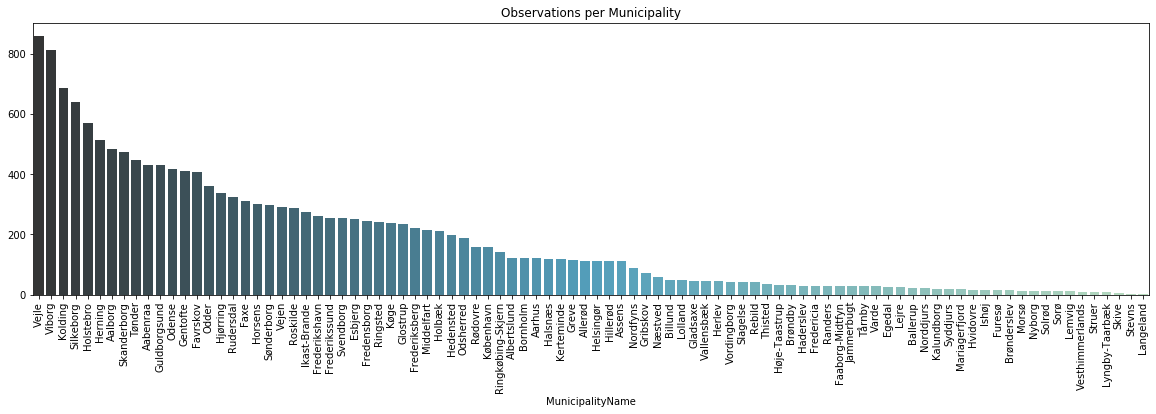

In [18]:
#Plotting the number of observations per Municipality
plt.figure(figsize=(20,5))
plt.title("Observations per Municipality")
df = traffic_data.groupby('MunicipalityName').FID.count().sort_values(ascending = False)
ax = sns.barplot(df.keys(), df.values, order=df.keys(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

In [19]:
#Removing the municipalities that have less then 30 observations
obsmunicipalities = traffic_data.groupby('MunicipalityName').FID.count().sort_values(ascending = False)
selectedmunicipalities = list(obsmunicipalities[obsmunicipalities>30].index)
traffic_data = traffic_data[traffic_data.MunicipalityName.isin(selectedmunicipalities)]

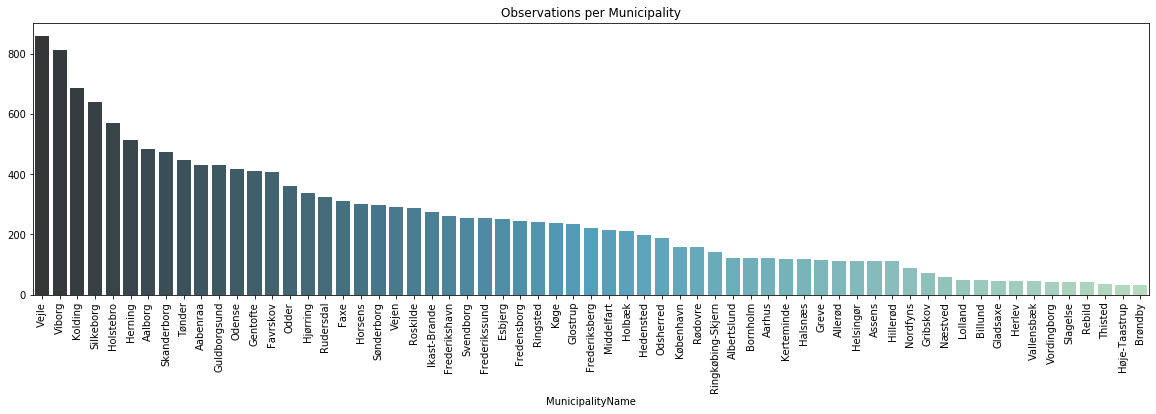

In [20]:
#Plotting the number of observations per Selected municipalities
plt.figure(figsize=(20,5))
plt.title("Observations per Municipality")
df = traffic_data.groupby('MunicipalityName').FID.count().sort_values(ascending = False)
ax = sns.barplot(df.keys(), df.values, order=df.keys(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

#### Other variables
We then explore the other variables, by displaying the  summary statistics and investigating potential erros.

In [21]:
traffic_data.describe()

RoadManager     Kilometer         Meter  Municipality          Year  \
count  15653.000000  15653.000000  15653.000000  15653.000000  15653.000000   
mean     469.304095      8.850955    379.577333    526.302434   2016.697758   
std      268.772851     30.361906    281.610034    221.825670      2.810015   
min        0.000000      0.000000      0.000000    101.000000   2000.000000   
25%      230.000000      0.000000    140.000000    320.000000   2015.000000   
50%      550.000000      0.000000    313.000000    580.000000   2017.000000   
75%      710.000000      3.000000    600.000000    727.000000   2019.000000   
max      860.000000    342.000000   3300.000000    860.000000   2020.000000   

       AverageDailyVehicles  AverageWeekdayDailyVehicles  DailyJulyTraffic  \
count          15653.000000                 15653.000000      15653.000000   
mean            3778.110905                  4186.496838       3545.200473   
std             8607.585843                  9452.833043       8567.165523   
min                0.000000                     0.000000          0.000000   
25%              479.000000                   528.000000        419.000000   
50%             1349.000000                  1500.000000       1203.000000   
75%             3829.000000                  4287.000000       3439.000000   
max           134915.000000                144973.000000     138913.000000   

       AverageSpeed   CountedDays  AverageDailyTrucks    SpeedLimit  \
count  15653.000000  15653.000000        15653.000000  15653.000000   
mean      50.861100     16.456398          328.870504     61.455057   
std       19.354803     26.259204         1042.094475     20.141757   
min        8.200000      1.300000          -74.000000     15.000000   
25%       37.300000      7.000000           26.000000     50.000000   
50%       48.000000      7.900000           83.000000     50.000000   
75%       61.300000     10.700000          261.000000     80.000000   
max      120.500000    365.800000        29273.000000    801.000000   

         Quantile15    Quantile85  PctOverSpeedLimit  PctOverSpeedLimit10  \
count  15653.000000  15653.000000       15653.000000         15653.000000   
mean      40.816738     60.506210          25.526953             7.871590   
std       17.731612     21.311722          25.385860            12.092178   
min        6.600000      9.500000           0.000000            -7.700000   
25%       27.600000     46.000000           2.400000             0.300000   
50%       38.800000     56.900000          17.600000             2.700000   
75%       49.400000     72.800000          43.500000            10.700000   
max      102.400000    137.700000          99.500000            98.200000   

       PctOverSpeedLimit20   PctOfTrucks     Longitude  
count         15653.000000  15653.000000  15653.000000  
mean              2.261675      7.664422     10.450671  
std               5.441748      5.865497      1.370574  
min             -17.200000     -3.100000      8.114568  
25%               0.100000      3.900000      9.437380  
50%               0.500000      6.700000      9.947871  
75%               2.200000      9.900000     11.950020  
max              93.400000    115.900000     15.149853

Below are some key takeaways from the summary statistics, which may be cause for furhter investigation.
* `Kilometer:` The maximum distance is 645, indicating that there is a measuring station 645 kilometers from the start of the road. This number is very high as roads in Denmark are not this long.
* `AverageDailyVehicles:` The minimum-value observation for the Average Daily Vehicles is negative, which should not be possible. The same is the case for `AverageWeekdayDailyVehicles`, `DailyJulyTraffic`, `PctOverSpeedLimit`, `PctOverSpeedLimit10`, `PctOverSpeedLimit20` and `PctOfTrucks`.
* `PctOfTrucks:` The maximum value for the Percantage of trucks on a road exceeds 100 % which should not be possible.
* `AverageWeekdayDailyVehicles:` Some maximum values for the daily number of vehicles are very high, but when compared to statistics from https://www.vejdirektoratet.dk/side/trafikkens-udvikling-i-tal, it is in accordance with the most populated roads in Denmark (Køge Bugt Motorvejen, Motorring 3)
* `SpeedLimit:` The maximum value is 801, which is indeed an odd speed limit.

Let's have a deeper look into some of these suspicious measurements. Let's look at the 645 km long road.

In [22]:
traffic_data[traffic_data["Kilometer"] == traffic_data["Kilometer"].max()]

FID Dataowner  \
15339  OPEN_DATA_NOEGLETAL_VIEW.fid--1778853a_17153cf...         0   

       RoadManager RoadId RoadPartId                 RoadName  Kilometer  \
15339          0.0     80         12  Frederikshavnmotorvejen      342.0   

       Meter                   Location  Municipality TypeOfVehicle  Year  \
15339  270.0  Sideanlæg: Øksenhede Vest         813.0      MOTORKTJ  2016   

       AverageDailyVehicles  AverageWeekdayDailyVehicles  DailyJulyTraffic  \
15339                 161.0                        163.0             234.0   

      Traffictype  AverageSpeed  CountedDays  AverageDailyTrucks  SpeedLimit  \
15339  UDPR FERIE          58.9         13.6                17.0         130   

       Quantile15  Quantile85  PctOverSpeedLimit  PctOverSpeedLimit10  \
15339        42.0        84.4                0.6                 -2.5   

       PctOverSpeedLimit20  PctOfTrucks  \
15339                 -5.7         10.3   

                                      Coordinates  Longitude  \
15339  POINT (587721.0000033564 6357194.99974163)  10.457762   

                Latitude MunicipalityName  
15339  57.34916415365037    Frederikshavn

A quick google search indicates that Frederikshavnmotorvejen is indeed not 645 kilometers. The longest road in Denmark is 310 kilometers, and it is the E45 high-speed road. (Ref: https://da.wikipedia.org/wiki/Motorveje_i_Danmark). Let's see how many roads exceed this number in the data set.

In [23]:
print("Amount of measurements stations placed more than 310 kilometers away from start of road: {}".format(sum(traffic_data["Kilometer"] > 310)))

Amount of measurements stations placed more than 310 kilometers away from start of road: 8


It is hard to say if these roads are faulty measurements as the documentation for the Kilometer variable reads : The mileage indication - the counting point has a so-called mileage (stationing), which is _typically_ the distance from the start of the road to the counting point; The mileage is then the mileage part of the mileage.
We therefore choose not to keep observations with high values for Kilometer in further analysis.

Below are counts for negative observations for columns which shouldn't contain negative values. The counts for observations exceeding 100 % in `PctOfTrucks` are also shown. Observations with speeding limits higher than 130 are also counted.

In [24]:
print("Amount of negative observations in AverageDailyVehicles columns: {}".format(sum(traffic_data["AverageDailyVehicles"] < 0)))
print("Amount of negative observations in AverageWeekdayDailyVehicles columns: {}".format(sum(traffic_data["AverageWeekdayDailyVehicles"] < 0)))
print("Amount of negative observations in DailyJulyTraffic columns: {}".format(sum(traffic_data["DailyJulyTraffic"] < 0)))
print("Amount of negative observations in AverageDailyTrucks columns: {}".format(sum(traffic_data["AverageDailyTrucks"] < 0)))
print("Amount of negative observations in PctOverSpeedLimit10 columns: {}".format(sum(traffic_data["PctOverSpeedLimit10"] < 0)))
print("Amount of negative observations in PctOverSpeedLimit20 columns: {}".format(sum(traffic_data["PctOverSpeedLimit20"] < 0)))
print("Amount of negative observations in PctOfTrucks columns: {}".format(sum(traffic_data["PctOfTrucks"] < 0)))
print("Amount of observations exceeding 100 % PctOfTrucks columns: {}".format(sum(traffic_data["PctOfTrucks"] > 100)))
print("Amount of observations exceeding a speeding limit of 130: {}".format(sum(traffic_data["SpeedLimit"] > 130)))

Amount of negative observations in AverageDailyVehicles columns: 0
Amount of negative observations in AverageWeekdayDailyVehicles columns: 0
Amount of negative observations in DailyJulyTraffic columns: 0
Amount of negative observations in AverageDailyTrucks columns: 1
Amount of negative observations in PctOverSpeedLimit10 columns: 17
Amount of negative observations in PctOverSpeedLimit20 columns: 25
Amount of negative observations in PctOfTrucks columns: 1
Amount of observations exceeding 100 % PctOfTrucks columns: 1
Amount of observations exceeding a speeding limit of 130: 1


The majority of observations are positive, with only a few negative ones. The observations are replaced with NaN values.

In [25]:
num = traffic_data._get_numeric_data()
num[num < 0] = np.nan
if traffic_data.PctOfTrucks.max() > 100:
    traffic_data.PctOfTrucks.replace([traffic_data.PctOfTrucks.max()], np.nan, inplace = True)
if traffic_data.SpeedLimit.max() > 130:
    traffic_data.SpeedLimit.replace([traffic_data.SpeedLimit.max()], np.nan, inplace = True)

#### Number of observations per Year

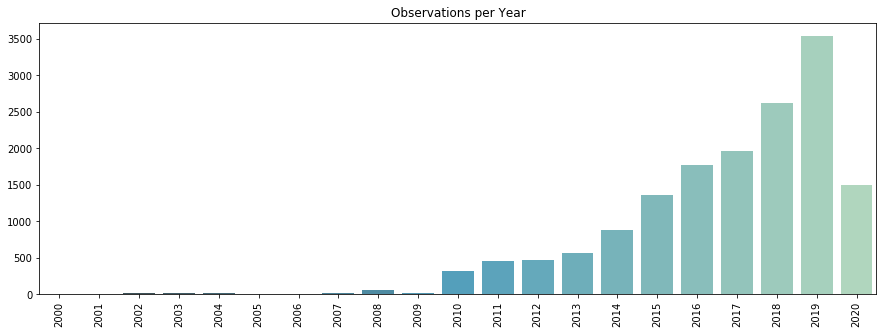

In [26]:
plt.figure(figsize=(15,5))
plt.title("Observations per Year")
df = traffic_data.Year.value_counts()
ax = sns.barplot(df.keys(), df.values, order=df.keys().sort_values(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

In [27]:
#MOVIE + Remove observation before 2010?

## 2. Data manipulation

We exclude data points where `AverageWeekdayDailyVehicles` is 0 as to not to divide by 0 - a total of 3 observations have 0-values in `AverageWeekdayDailyVehicles`.

In [28]:
traffic_data = traffic_data.dropna(subset=['SpeedLimit', 'AverageSpeed'])
#traffic_data = traffic_data.astype({'SpeedLimit': 'float64'})

In [29]:
traffic_data["AverageDifferenceSpeedLimitAvgSpeed"] =  traffic_data.SpeedLimit - traffic_data.AverageSpeed

In [30]:
#We exclude data points where AverageWeekdayDailyVehicles is 0 as to not to divide by 0 - a total of 3 observations have 0-values in AverageWeekdayDailyVehicles.
traffic_data = traffic_data[traffic_data.AverageWeekdayDailyVehicles != 0].reset_index(drop=True)

traffic_data["JulyWeekdaysRatio"] = traffic_data.DailyJulyTraffic / traffic_data.AverageWeekdayDailyVehicles

## 3. Summary statistics and variable distributions

In [31]:
traffic_data.describe()

RoadManager     Kilometer         Meter  Municipality          Year  \
count  15649.000000  15649.000000  15649.000000  15649.000000  15649.000000   
mean     469.284299      8.852770    379.507253    526.297207   2016.697808   
std      268.796530     30.365559    281.595459    221.844306      2.810270   
min        0.000000      0.000000      0.000000    101.000000   2000.000000   
25%      230.000000      0.000000    140.000000    320.000000   2015.000000   
50%      550.000000      0.000000    313.000000    580.000000   2017.000000   
75%      710.000000      3.000000    600.000000    727.000000   2019.000000   
max      860.000000    342.000000   3300.000000    860.000000   2020.000000   

       AverageDailyVehicles  AverageWeekdayDailyVehicles  DailyJulyTraffic  \
count          15649.000000                 15649.000000      15649.000000   
mean            3778.938590                  4187.478880       3545.984727   
std             8608.525526                  9453.836726       8568.116108   
min                1.000000                     1.000000          0.000000   
25%              479.000000                   529.000000        419.000000   
50%             1350.000000                  1500.000000       1204.000000   
75%             3830.000000                  4287.000000       3439.000000   
max           134915.000000                144973.000000     138913.000000   

       AverageSpeed   CountedDays  AverageDailyTrucks    SpeedLimit  \
count  15649.000000  15649.000000        15648.000000  15649.000000   
mean      50.860841     16.458381          328.971115     61.406160   
std       19.356639     26.262247         1042.245068     19.255843   
min        8.200000      1.300000            0.000000     15.000000   
25%       37.300000      7.000000           26.000000     50.000000   
50%       48.000000      7.900000           83.000000     50.000000   
75%       61.300000     10.700000          261.000000     80.000000   
max      120.500000    365.800000        29273.000000    130.000000   

         Quantile15    Quantile85  PctOverSpeedLimit  PctOverSpeedLimit10  \
count  15649.000000  15649.000000       15649.000000         15632.000000   
mean      40.816180     60.506224          25.529280             7.885984   
std       17.733432     21.313644          25.384612            12.092708   
min        6.600000      9.500000           0.000000             0.000000   
25%       27.600000     46.000000           2.400000             0.300000   
50%       38.800000     56.900000          17.600000             2.700000   
75%       49.400000     72.800000          43.500000            10.700000   
max      102.400000    137.700000          99.500000            98.200000   

       PctOverSpeedLimit20   PctOfTrucks     Longitude  \
count         15624.000000  15647.000000  15649.000000   
mean              2.276843      7.657283     10.450688   
std               5.428012      5.797536      1.370686   
min               0.000000      0.000000      8.114568   
25%               0.100000      3.900000      9.436983   
50%               0.500000      6.700000      9.947776   
75%               2.200000      9.900000     11.950387   
max              93.400000     99.000000     15.149853   

       AverageDifferenceSpeedLimitAvgSpeed  JulyWeekdaysRatio  
count                         15649.000000       15649.000000  
mean                             10.545319           0.824215  
std                              13.157354           0.256855  
min                             -39.000000           0.000000  
25%                               1.300000           0.719383  
50%                               8.500000           0.756635  
75%                              18.000000           0.831041  
max                              99.700000           8.800000

As seen from the summary statistics table, the processed data set has been reduced to contain 15652 observations. It it is noted that none of the observations are subceeding or exceeding reasonable limits for the given variable. This is of coruse not a guarantee that the observations are free from errors or potential outliers, but rather that the obvious ones were removed.

Having a closer look at the variables `Kilometer`, `CountedDays` and the variables denoting the amount of vehicles and speeding vehicles, we see that their maximum values are far from the Inter Quartile Range, indicating that few observations have very large values - in other words, some few roads have very different behaviours compared to the majority of roads. This could be due to the large difference in traffic levels when comparing low capacity roads such as urban streets with highways. A potential casue for roads with a lot of speeding could be due to incorrect speeding limits, or lack of transparency for the particular speeding limit.

Below are histograms for a subset of the variables which we find interesting.

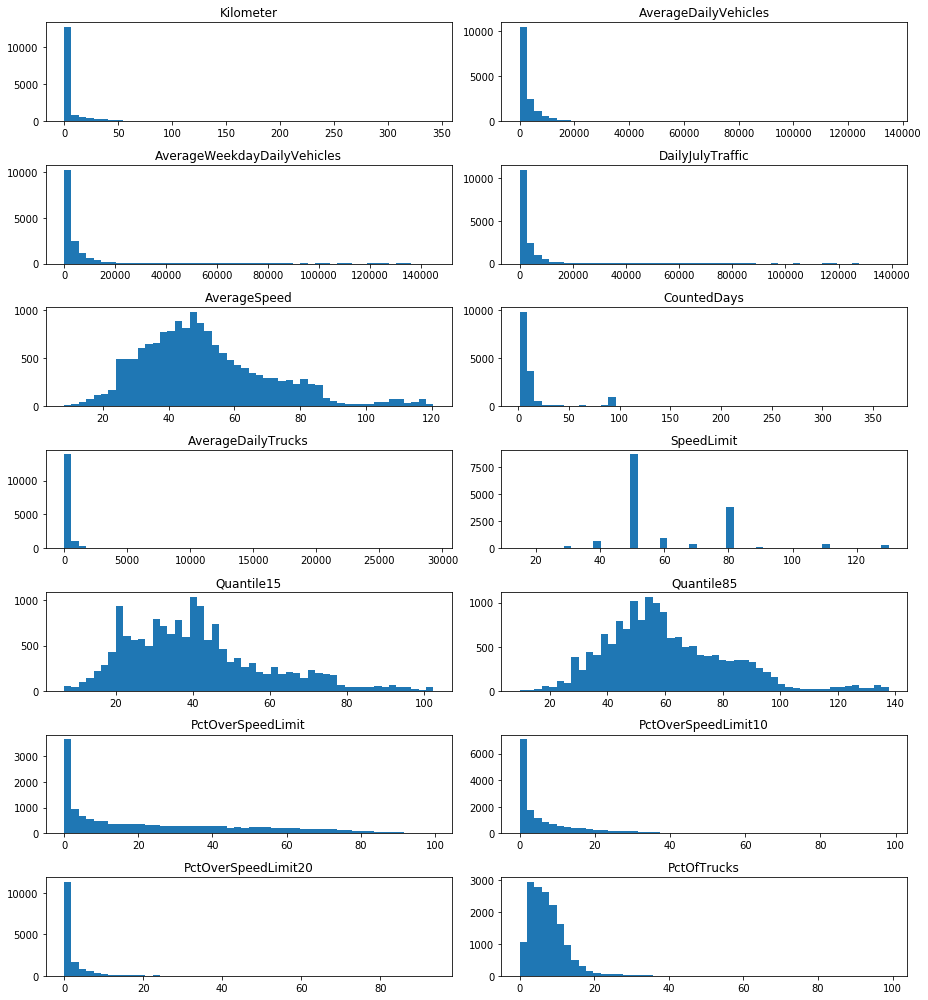

In [32]:
cols_to_plot = ['Kilometer', 'AverageDailyVehicles',
       'AverageWeekdayDailyVehicles', 'DailyJulyTraffic',
       'AverageSpeed', 'CountedDays',
       'AverageDailyTrucks', 'SpeedLimit', 'Quantile15', 'Quantile85',
       'PctOverSpeedLimit', 'PctOverSpeedLimit10', 'PctOverSpeedLimit20',
       'PctOfTrucks'] #ADD NEW VARIABLES

fig = plt.figure(figsize=(13,14))
for i in range(len(cols_to_plot)):
    fig.add_subplot(7, 2, i+1)
    plt.hist(pd.to_numeric(traffic_data[cols_to_plot[i]]), bins = 50)
    plt.title(cols_to_plot[i])
    plt.tight_layout()
    
plt.show()

As suspected in the summary statiscis, many of the variables have tendencies to have long tails to the right, which indicate that there are some few high valued observations for many of them. Despite these being outliers compared to the rest of the data, the values are still seen as realistic, and therefore kept in the data set for further analysis.

## 4. Data Exploration

### 4A. Temporal trends

In [33]:
vars_to_plot = ['AverageDailyVehicles', 'AverageSpeed', 'PctOfTrucks', 
                'PctOverSpeedLimit', 'PctOverSpeedLimit10', 'PctOverSpeedLimit20']

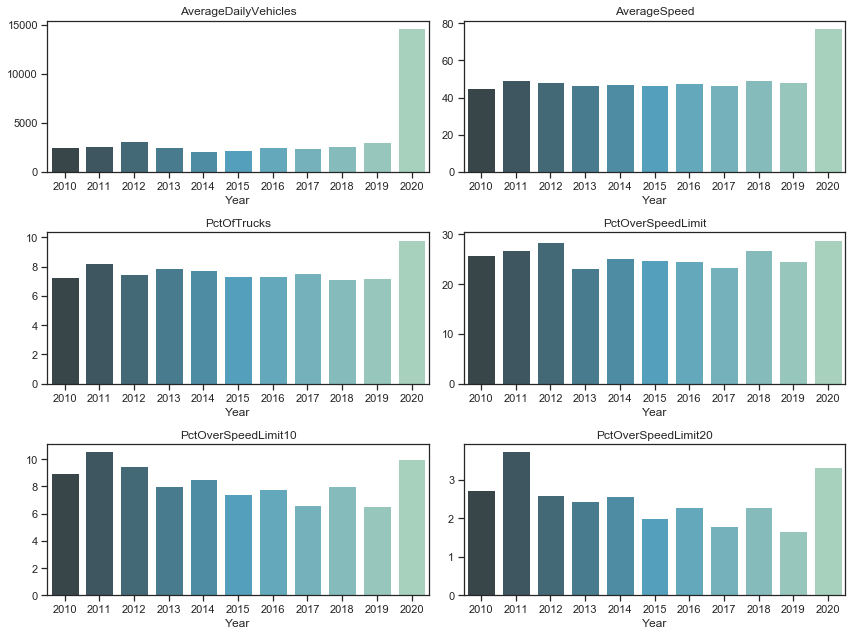

In [105]:
fig = plt.figure(figsize=(12,9))
for i in range(len(vars_to_plot)):
    fig.add_subplot(3, 2, i+1)
    df = traffic_data[traffic_data.Year > 2009].groupby('Year')[vars_to_plot[i]].mean().sort_values(ascending = False)
    sns.barplot(df.keys(), df.values, palette="GnBu_d")
    plt.title(vars_to_plot[i])
    plt.tight_layout()
    
plt.show()

The `AverageDailyVehicles` and the `AverageSpeed` variables take relatively stable values throughout the years, but register a peak in 2020.
Therefore, in the cells below, we will check if this is due to data errors (i.e. irreasonably high numbers recorded in 2020) or if the entire distribution in 2020 is shifted towards higher values and the average reflects that distribution.

#### Average Speed

In [35]:
#Checking the maximum average speed recorded in the last 4 years
for i in [2017,2018,2019,2020]:
    print("Maximum average speed registered in {}: {}".format(i,traffic_data[traffic_data.Year == i].AverageSpeed.max()))

Maximum average speed registered in 2017: 90.4
Maximum average speed registered in 2018: 114.3
Maximum average speed registered in 2019: 115.9
Maximum average speed registered in 2020: 120.5


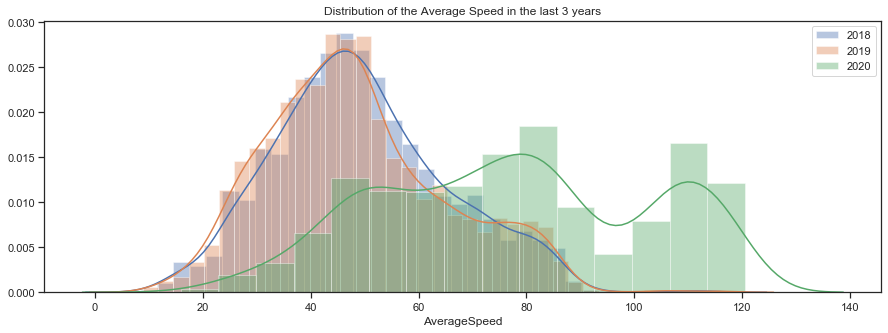

In [102]:
#Plotting the distribution of the average speed in the last 3 years
plt.figure(figsize=(15,5))
for i in [2018,2019,2020]:
    sns.distplot(traffic_data[traffic_data.Year == i]["AverageSpeed"], label= i)
    plt.title("Distribution of the Average Speed in the last 3 years")
    plt.legend()

#### Number of Vehicles

In [37]:
#Checking the maximum number of vehicles recorded in the last 4 years
for i in [2017,2018,2019,2020]:
    print("Maximum numbers of vehicles registered in {}: {}".format(i,traffic_data[traffic_data.Year == i].AverageDailyVehicles.max()))

Maximum numbers of vehicles registered in 2017: 33729.0
Maximum numbers of vehicles registered in 2018: 101195.0
Maximum numbers of vehicles registered in 2019: 116145.0
Maximum numbers of vehicles registered in 2020: 134915.0


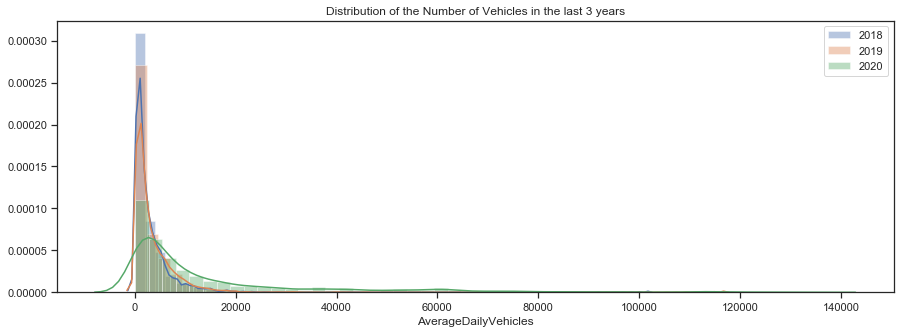

In [113]:
#Plotting the distribution of the average number of daily vehicles in the last 3 years
plt.figure(figsize=(15,5))
for i in [2018,2019,2020]:
    sns.distplot(traffic_data[traffic_data.Year == i]["AverageDailyVehicles"], label= i)
    plt.title("Distribution of the Number of Vehicles in the last 3 years")
    plt.legend()

As it can be seen, both for the `AverageDailyVehicles` and the `AverageSpeed` variables, the peaks in 2020 does not seem to be due to irreasonably high values. Instead, the peak might be due to different types of streets being measured. Indeed, for instance, if more measurements in 2020 were performed in highways, the resulting average speed and number of vehicles would be higher. 

We can verify this hypothesis by comparing the `SpeedLimit` variable throughout the years, which gives us an indication about the types of roads where the measurements have been performed.

#### Speed Limit

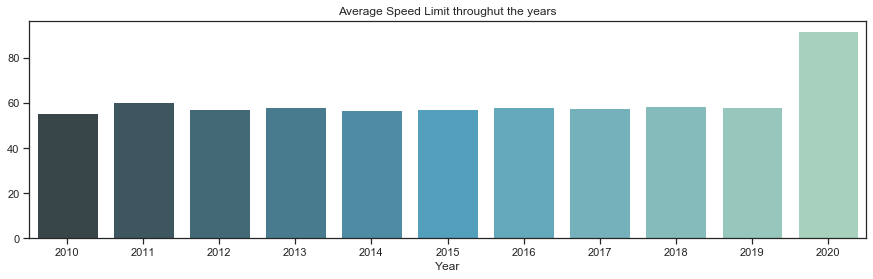

In [115]:
plt.figure(figsize=(15,4))
plt.title("Average Speed Limit throughut the years")
df = traffic_data[traffic_data.Year > 2009].groupby('Year')['SpeedLimit'].mean().sort_values(ascending = False)
sns.barplot(df.keys(), df.values, palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

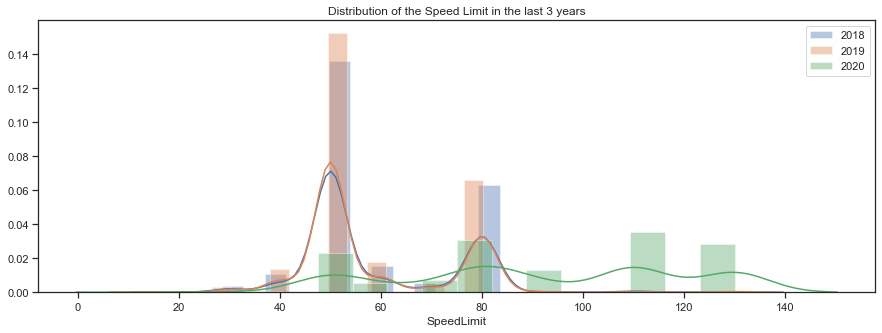

In [114]:
#Plotting the distribution of the speed limit in the last 3 years
plt.figure(figsize=(15,5))
for i in [2018,2019,2020]:
    sns.distplot(traffic_data[traffic_data.Year == i]["SpeedLimit"], label= i)
    plt.title("Distribution of the Speed Limit in the last 3 years")
    plt.legend()

While in the previous years the measurements have been performed in roads that have a speed limit lower than 80km/h, in 2020 a substantial fraction of measurements has been performed in high-speed roads. 
Therefore, the main increase in speed might be driven by a different sample of roads.

To confirm that, we plot the average value of some variables throughout the years, by only considering urban roads (`SpeedLimit` lower than 50km/h). 

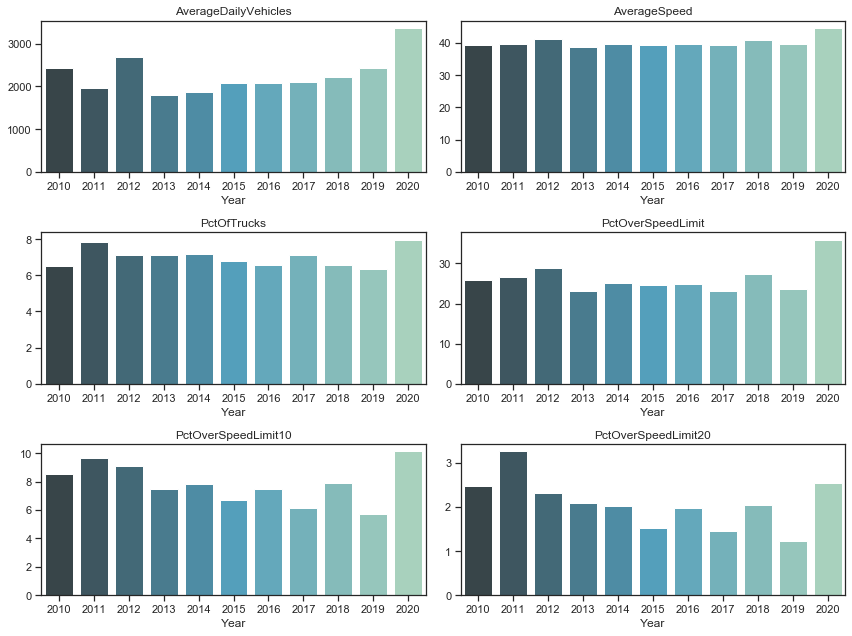

In [91]:
fig = plt.figure(figsize=(12,9))
for i in range(len(vars_to_plot)):
    fig.add_subplot(3, 2, i+1)
    df = traffic_data[traffic_data.Year > 2009][traffic_data.SpeedLimit<51].groupby('Year')[vars_to_plot[i]].mean().sort_values(ascending = False)
    sns.barplot(df.keys(), df.values, palette="GnBu_d")
    plt.title(vars_to_plot[i])
    plt.tight_layout()
    
plt.show()

### 4B. Types of roads

It is interesting to explore whether the behavior of Danes changes in the different types of roads (i.e. roads with different `SpeedLimit` values).
Firstly, we look at the number of observations per `SpeedLimit` values.

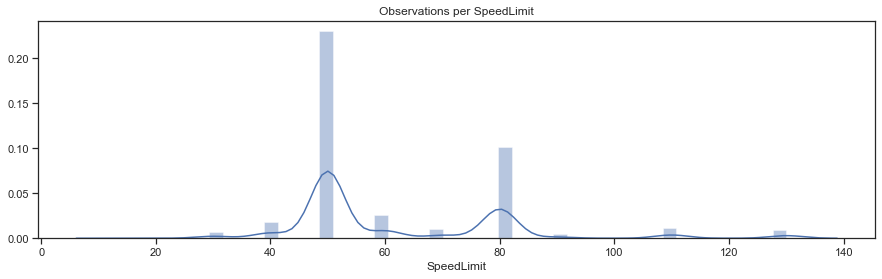

In [110]:
plt.figure(figsize=(15,4))
sns.distplot(traffic_data["SpeedLimit"], label= i)
plt.title("Observations per SpeedLimit");

We can see that the majority of the measurements has been performed in roads that have a `SpeedLimit`of either 50km/h or 80 km/h. The observations belonging to these two types of roads might have a big effect when computing a correlation between `SpeedLimit` and the other variables.

We now look into the behavior of Danes changes in the different types of roads.



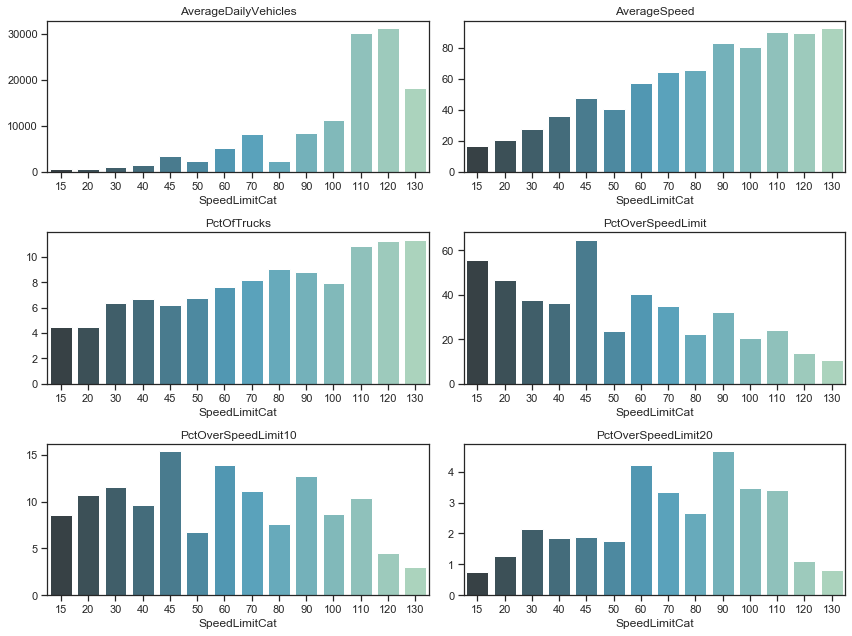

In [92]:
speedlimits = np.sort(traffic_data.SpeedLimit.unique().astype(int))
list_ordering = list(speedlimits)
traffic_data["SpeedLimitCat"] = pd.Categorical(traffic_data["SpeedLimit"], categories=list_ordering)

fig = plt.figure(figsize=(12,9))
for i in range(len(vars_to_plot)):
    fig.add_subplot(3, 2, i+1)
    df = traffic_data[traffic_data.Year > 2009].groupby('SpeedLimitCat')[vars_to_plot[i]].mean()
    sns.barplot(df.keys(), df.values, palette="GnBu_d")
    plt.title(vars_to_plot[i])
    plt.tight_layout()
    
plt.show()

### 4.C Correlations

It is noted that when the speed limits are higher, it is naturally followed by an increase in the average speed. But it can also be seen that the percentage of people speeding is increasing. To test this hypothesis the correlation between the speed limits and the percentage of people speeding for the three variables are calculated below.

In [44]:
#print(traffic_data.SpeedLimit.corr(traffic_data.PctOverSpeedLimit))
#print(traffic_data.SpeedLimit.corr(traffic_data.PctOverSpeedLimit10))
#print(traffic_data.SpeedLimit.corr(traffic_data.PctOverSpeedLimit20))

|         Correlation-Combinations                        | Correlation value |
|---------------------------------------------------------|-------------------|
| Correlation between SpeedLimit and PctOverSpeedlimit:   | -0.0851           |
| Correlation between SpeedLimit and PctOverSpeedlimit10: | 0.00183           |
| Correlation between SpeedLimit and PctOverSpeedlimit20: | 0.0564            |

The correlation values indicate that the connection between the speed limits and the percentage of people driving over them is not very strong. 

Let's look into the correlation between the speed limits and the difference in km/h to the speed limits. Perhaps drivers are more prone to driving a bit faster than the speed limit, when the speed limit is high. This variable is a bit more granulated than the PctOverSpeedLimit10 and PctOverSpeedLimit20, since it is measured as absolute differences to the speed limit, rather than in brackets.

In [45]:
# Get correlation and confidence interval for correlation
r, p, lower, upper = pearsonr_ci(traffic_data.SpeedLimit.values, traffic_data.AverageDifferenceSpeedLimitAvgSpeed)

|         Correlation-Combination                         | Correlation value |
|---------------------------------------------------------|-------------------|
| Correlation between SpeedLimit and AverageDifferenceSpeedLimitAvgSpeed:   | 0.334           |

Here we see a stronger correlation than before, indicating that the people are more likely to drive a bit faster on roads with higher speed limits. This is somewhat expected as the absolute change in driving speed is smaller when already driving fast compared to slow driving.

Calculating the confidence interval for the correlation reveals that the 95 % confidence interval limits are (0.320 , 0.348) - indicating that the correlation is statistically significant.

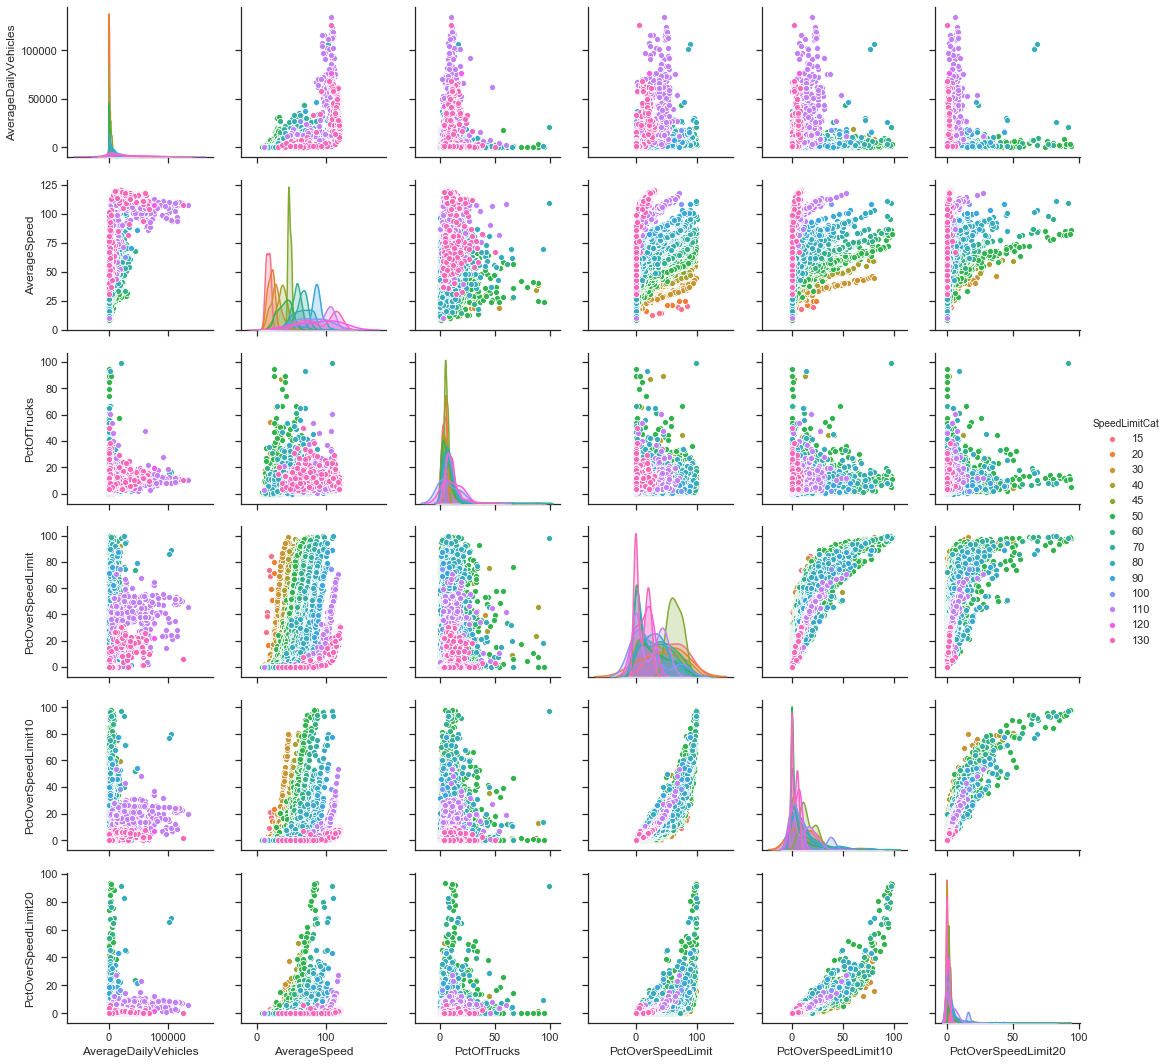

In [46]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(traffic_data, vars = vars_to_plot , hue="SpeedLimitCat")

### 4D. Comparison among municipalities

#### Number of cars in 24h 

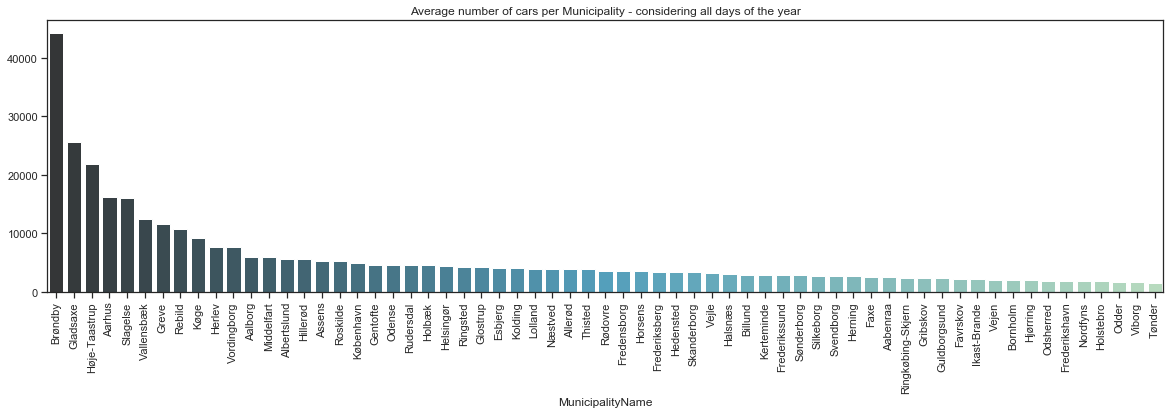

In [47]:
#Considering all days of the year (CHANGE TO MAP)
plt.figure(figsize=(20,5))
plt.title("Average number of cars per Municipality - considering all days of the year")
df = traffic_data.groupby('MunicipalityName').AverageDailyVehicles.mean().sort_values(ascending = False)
ax = sns.barplot(df.keys(), df.values, order = df.keys(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

#### Comparing the number of cars in July vs a working day
Some kommunes (values <1, on the left) experience a drop in traffic in July (business areas?), some (values >1, on the right) experience an increase in traffic in July (holiday destinations?).

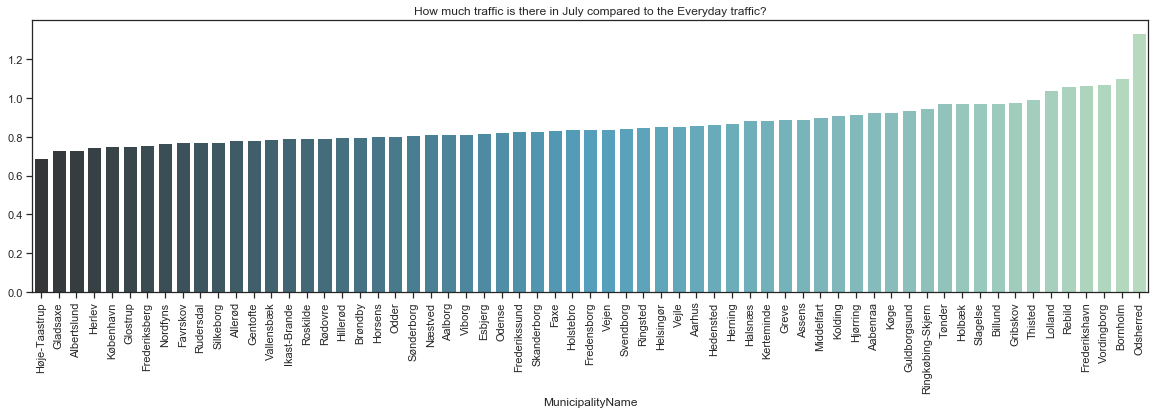

In [48]:
#Seasonal traffic (CHANGE TO MAP)
plt.figure(figsize=(20,5))
plt.title("How much traffic is there in July compared to the Everyday traffic?")
df = (traffic_data.groupby('MunicipalityName').DailyJulyTraffic.mean() / traffic_data.groupby('MunicipalityName').AverageWeekdayDailyVehicles.mean()).sort_values()
ax = sns.barplot(df.keys(), df.values, palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

#### Number of trucks

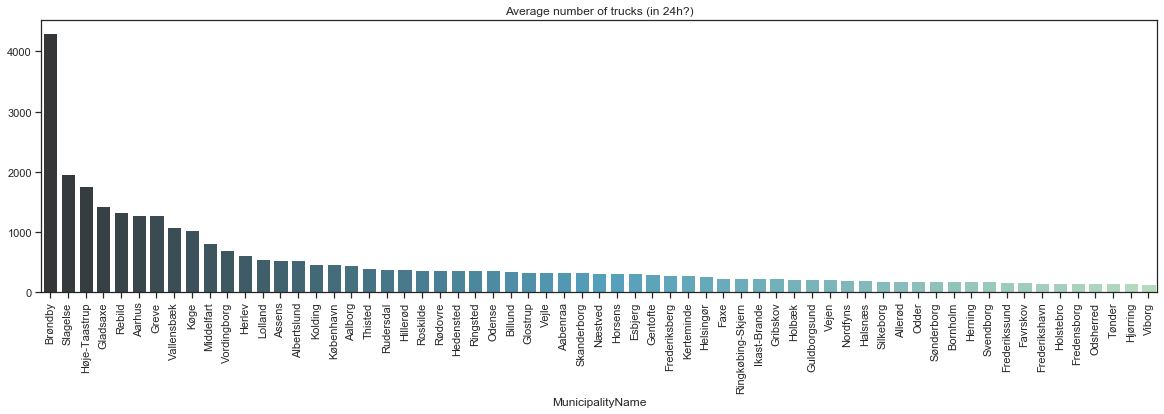

In [49]:
plt.figure(figsize=(20,5))
plt.title("Average number of trucks (in 24h?)")
df = traffic_data.groupby('MunicipalityName').AverageDailyTrucks.mean().sort_values(ascending = False)
ax = sns.barplot(df.keys(), df.values, order = df.keys(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

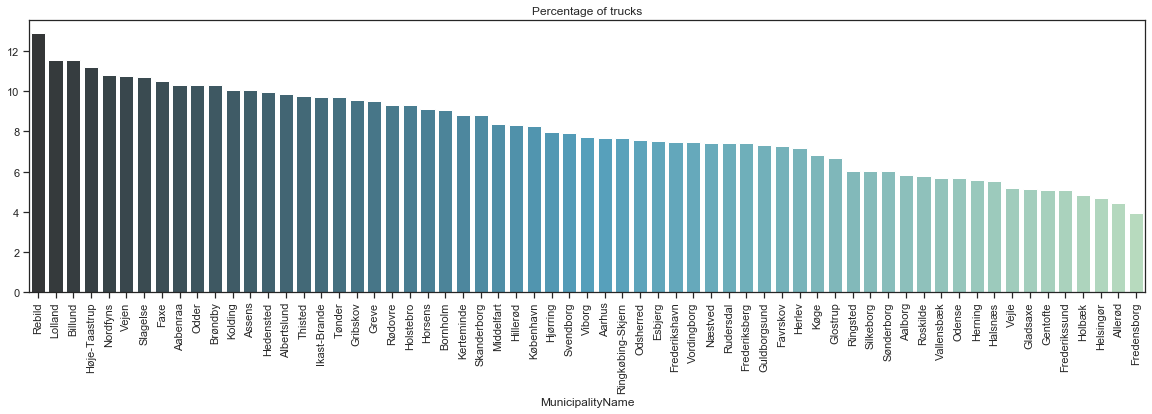

In [50]:
plt.figure(figsize=(20,5))
plt.title("Percentage of trucks")
df = traffic_data.groupby('MunicipalityName').PctOfTrucks.mean().sort_values(ascending = False)
ax = sns.barplot(df.keys(), df.values, order = df.keys(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

#### Traffic types 


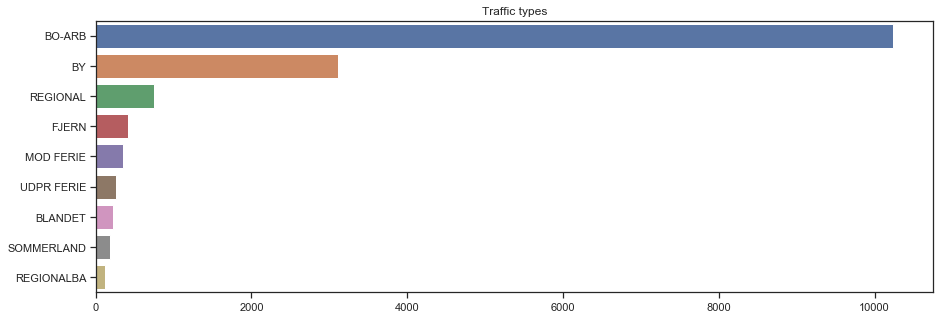

In [51]:
plt.figure(figsize=(15,5))
plt.title("Traffic types")
df = traffic_data.Traffictype.value_counts()
ax = sns.barplot(df.values, df.keys())

#### Speed

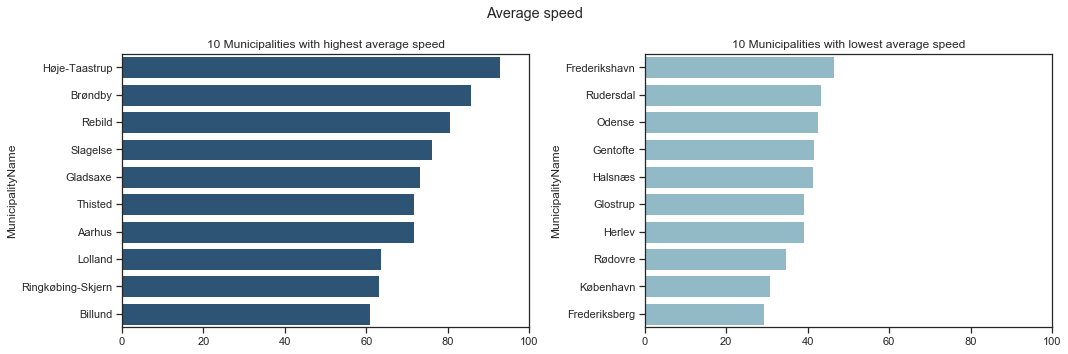

In [52]:
#Average Speed
plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("10 Municipalities with highest average speed")
df = traffic_data.groupby('MunicipalityName').AverageSpeed.mean().sort_values(ascending = False).head(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#215580")
ax.set(xlim=(0, 100))

plt.subplot(1, 2, 2)
plt.title("10 Municipalities with lowest average speed")
df = traffic_data.groupby('MunicipalityName').AverageSpeed.mean().sort_values(ascending = False).tail(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#88bdcf")
ax.set(xlim=(0, 100))

plt.suptitle('Average speed')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

#### Fast drivers

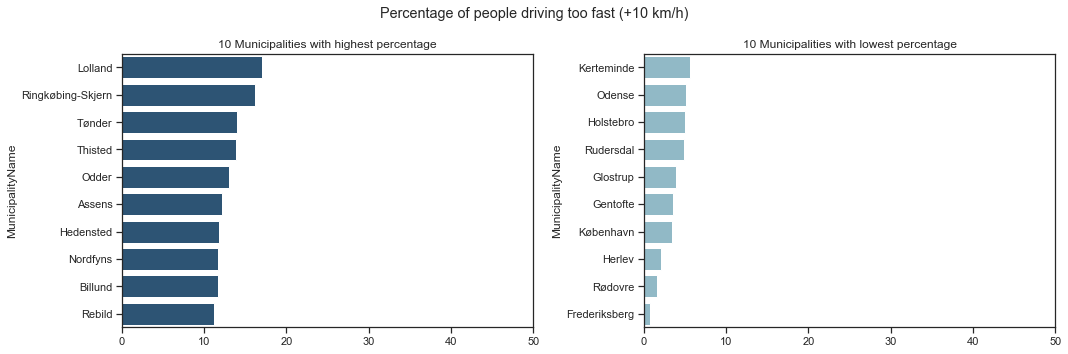

In [53]:
#Percentage of people driving too fast (+10 km/h)

plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("10 Municipalities with highest percentage")
df = traffic_data.groupby('MunicipalityName').PctOverSpeedLimit10.mean().sort_values(ascending = False).head(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#215580")
ax.set(xlim=(0, 50))

plt.subplot(1, 2, 2)
plt.title("10 Municipalities with lowest percentage")
df = traffic_data.groupby('MunicipalityName').PctOverSpeedLimit10.mean().sort_values(ascending = False).tail(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#88bdcf")
ax.set(xlim=(0, 50))

plt.suptitle('Percentage of people driving too fast (+10 km/h)')
plt.tight_layout()
plt.subplots_adjust(top=0.85)


# II. Explaining the driving behavior
## 1.  Addressing our research questions


### Which municipalities register the highest/lowest percentage of fast drivers?

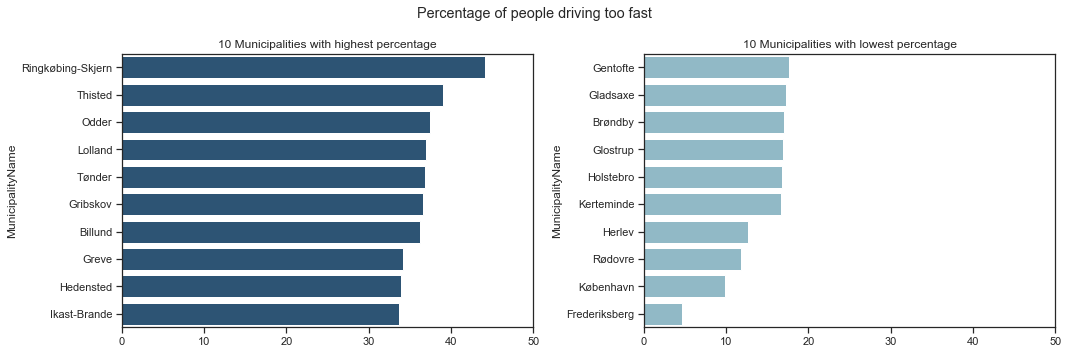

In [54]:
#Percentage of people driving too fast
plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("10 Municipalities with highest percentage")
df = traffic_data.groupby('MunicipalityName').PctOverSpeedLimit.mean().sort_values(ascending = False).head(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#215580")
ax.set(xlim=(0, 50))

plt.subplot(1, 2, 2)
plt.title("10 Municipalities with lowest percentage")
df = traffic_data.groupby('MunicipalityName').PctOverSpeedLimit.mean().sort_values(ascending = False).tail(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#88bdcf")
ax.set(xlim=(0, 50))

plt.suptitle('Percentage of people driving too fast')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [55]:
#MAP?
#Stacked barchart

### Which municipalities register the highest/lowest percentage of people (among the fast drivers) driving +20km/h above the limit?

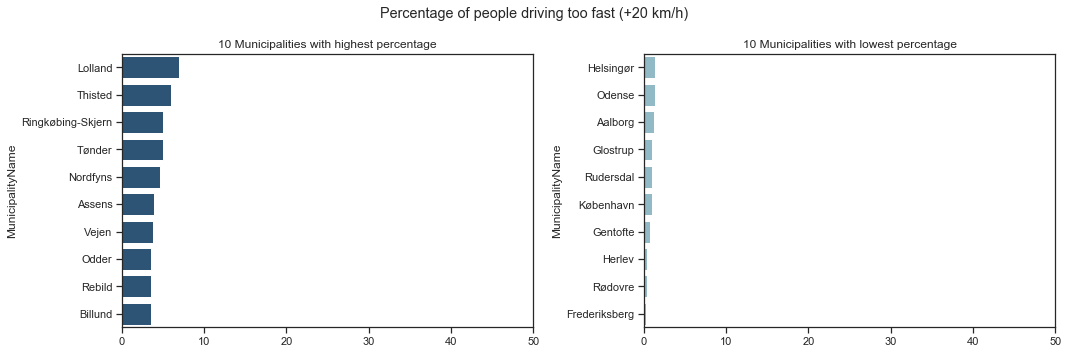

In [56]:
#Percentage of people driving too fast (+20 km/h)

plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("10 Municipalities with highest percentage")
df = traffic_data.groupby('MunicipalityName').PctOverSpeedLimit20.mean().sort_values(ascending = False).head(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#215580")
ax.set(xlim=(0, 50))

plt.subplot(1, 2, 2)
plt.title("10 Municipalities with lowest percentage")
df = traffic_data.groupby('MunicipalityName').PctOverSpeedLimit20.mean().sort_values(ascending = False).tail(10)
ax = sns.barplot(df.values, df.keys(), order = df.keys(), color="#88bdcf")
ax.set(xlim=(0, 50))

plt.suptitle('Percentage of people driving too fast (+20 km/h)')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

### Which roads register the highest/lowest percentage of fast drivers?

# Appendix

### Comparison among focus-municipalities

#### Selection of focus municipalities

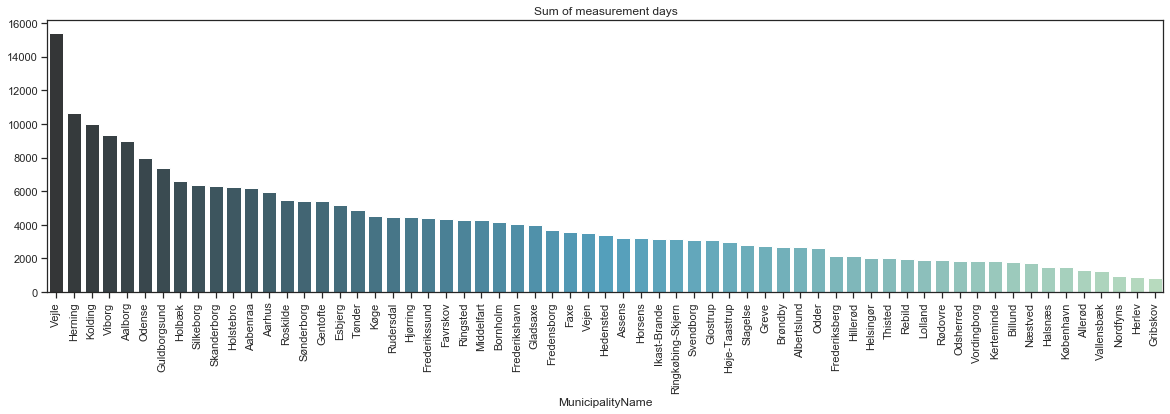

In [57]:
plt.figure(figsize=(20,5))
plt.title("Sum of measurement days")
df = traffic_data.groupby('MunicipalityName').CountedDays.sum().sort_values(ascending = False)
ax = sns.barplot(df.keys(), df.values, order = df.keys(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

In [58]:
base = 3
traffic_data["CountedDaysLog"]= np.log(traffic_data.CountedDays+1) / np.log(base)

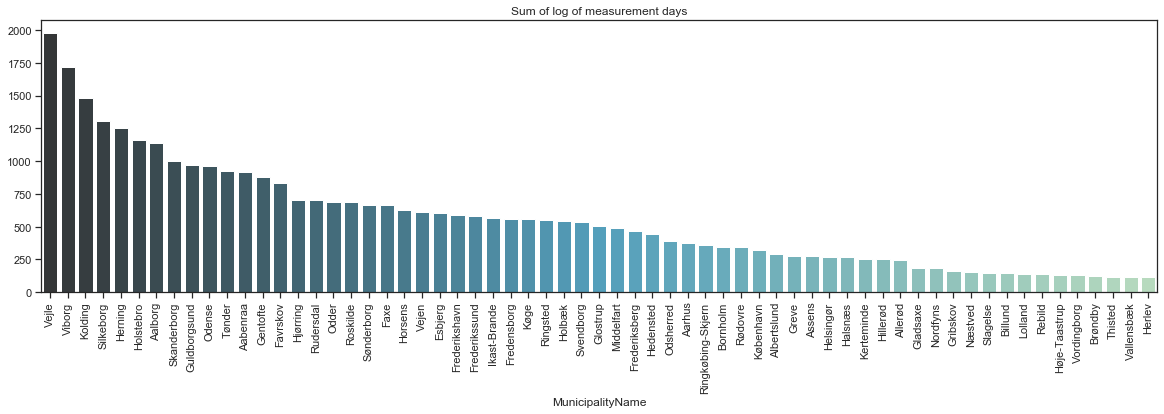

In [59]:
plt.figure(figsize=(20,5))
plt.title("Sum of log of measurement days")
df = traffic_data.groupby('MunicipalityName').CountedDaysLog.sum().sort_values(ascending = False)
ax = sns.barplot(df.keys(), df.values, order = df.keys(), palette="GnBu_d")
plt.setp(ax.get_xticklabels(), rotation=90);

In [60]:
focusmunicipalitiessize = 13
mostcountedlog = traffic_data.groupby('MunicipalityName').CountedDaysLog.sum().sort_values(ascending = False)
mostcounted = traffic_data.groupby('MunicipalityName').CountedDays.sum().sort_values(ascending = False)
newmun = (set(mostcountedlog[:focusmunicipalitiessize].index) - set(mostcounted[:focusmunicipalitiessize].index))
lostmun = (set(mostcounted[:focusmunicipalitiessize].index) - set(mostcountedlog[:focusmunicipalitiessize].index))

In [61]:
lostmun

{'Aarhus', 'Holbæk'}

In [62]:
newmun

{'Gentofte', 'Tønder'}

In [63]:
mostcountedlog

MunicipalityName
Vejle                1974.797059
Viborg               1718.130900
Kolding              1482.235755
Silkeborg            1302.713300
Herning              1249.691214
Holstebro            1157.460382
Aalborg              1134.139744
Skanderborg          1001.081865
Guldborgsund          968.173368
Odense                961.054904
Tønder                927.305483
Aabenraa              917.116842
Gentofte              875.488457
Favrskov              829.641442
Hjørring              705.431691
Rudersdal             699.155562
Odder                 691.087060
Roskilde              688.815466
Sønderborg            665.443457
Faxe                  661.804896
Horsens               628.435344
Vejen                 614.529666
Esbjerg               604.436335
Frederikshavn         584.621576
Frederikssund         581.148566
Ikast-Brande          568.749425
Fredensborg           556.169746
Køge                  554.826840
Ringsted              550.733190
Holbæk                545.

In [64]:
focusmunicipalities = mostcountedlog[:focusmunicipalitiessize].index
# Add Copenhagen because it is the capital
focusmunicipalities = list(focusmunicipalities)
focusmunicipalities.append("København")

In [65]:
focusmunicipalities

['Vejle',
 'Viborg',
 'Kolding',
 'Silkeborg',
 'Herning',
 'Holstebro',
 'Aalborg',
 'Skanderborg',
 'Guldborgsund',
 'Odense',
 'Tønder',
 'Aabenraa',
 'Gentofte',
 'København']

#### Plot variables against focus municipalities

In [66]:
data_to_focus = traffic_data[traffic_data.MunicipalityName.isin(focusmunicipalities)]
data_to_focus = data_to_focus[data_to_focus.Year > 2012]

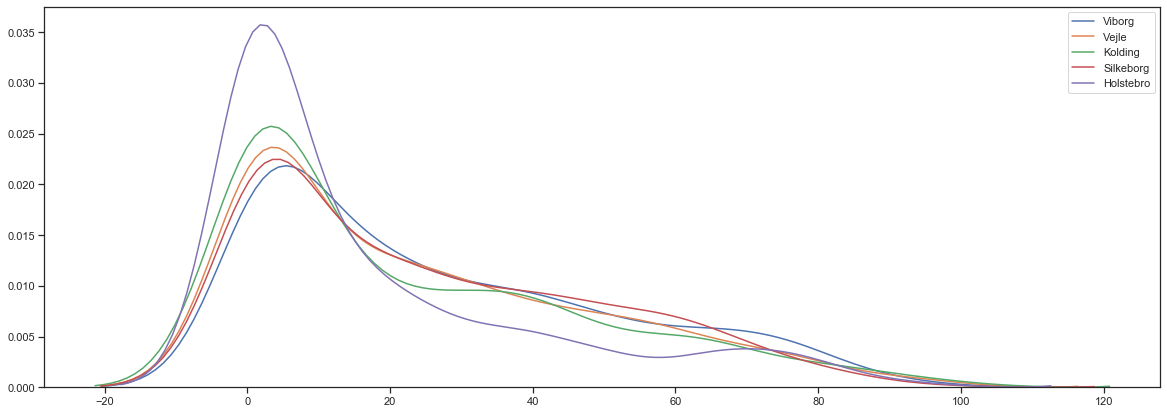

In [67]:
#Work in progress (to compare the distribution of more municipalities in only one chart)
plt.figure(figsize=(20,7))
for i in data_to_focus.MunicipalityName.value_counts().head(5).keys():
    sns.kdeplot(data_to_focus[data_to_focus.MunicipalityName == i]["PctOverSpeedLimit"], label= i )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025258325F28>,
      dtype=object)

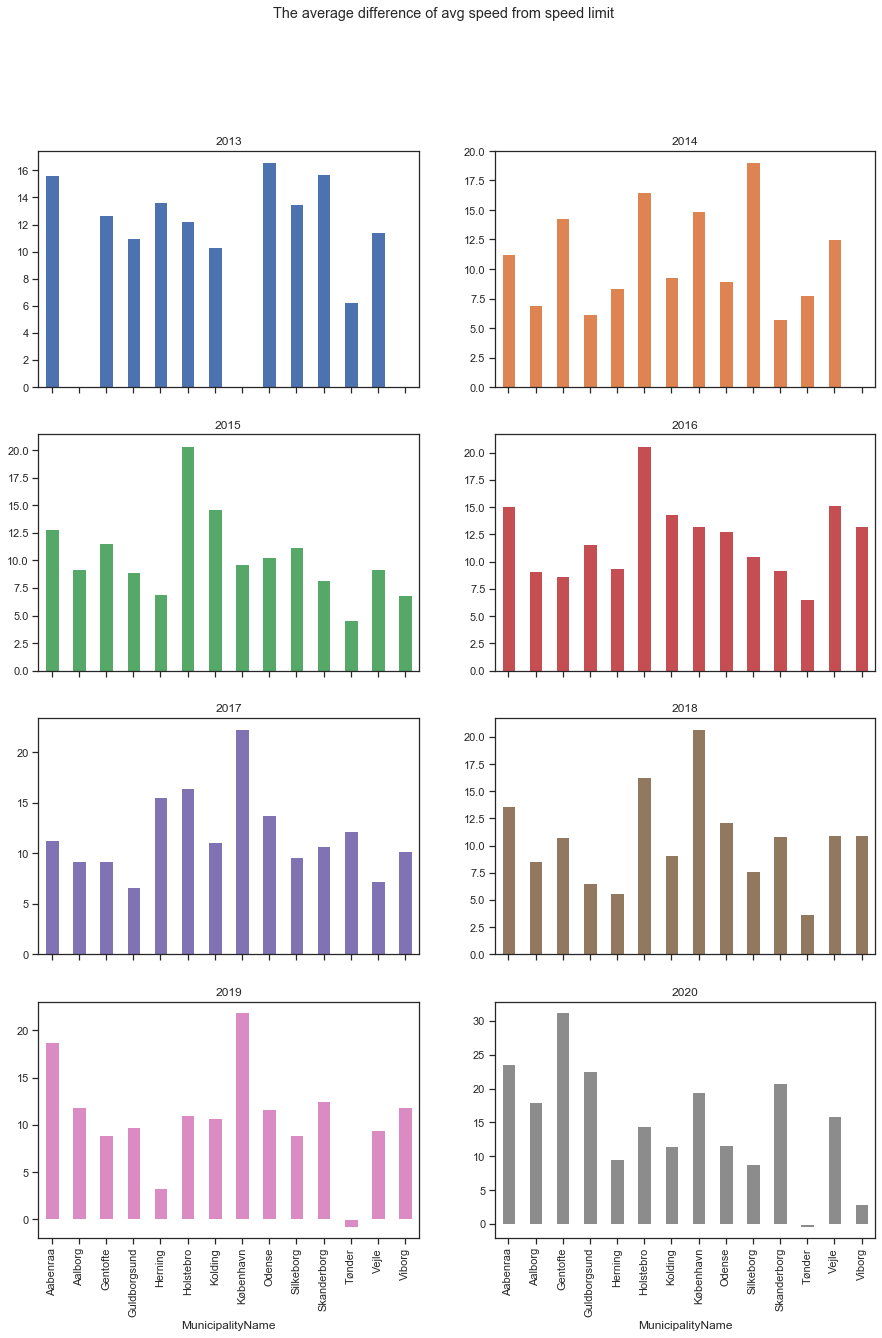

In [68]:
focus_counth =data_to_focus.groupby(['MunicipalityName', 'Year'])['AverageDifferenceSpeedLimitAvgSpeed'].mean()
focus_counth.unstack().plot.bar(subplots=True,layout=(4,2), figsize=(15,20), legend=False, title='The average difference of avg speed from speed limit')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002525C5F5358>,
      dtype=object)

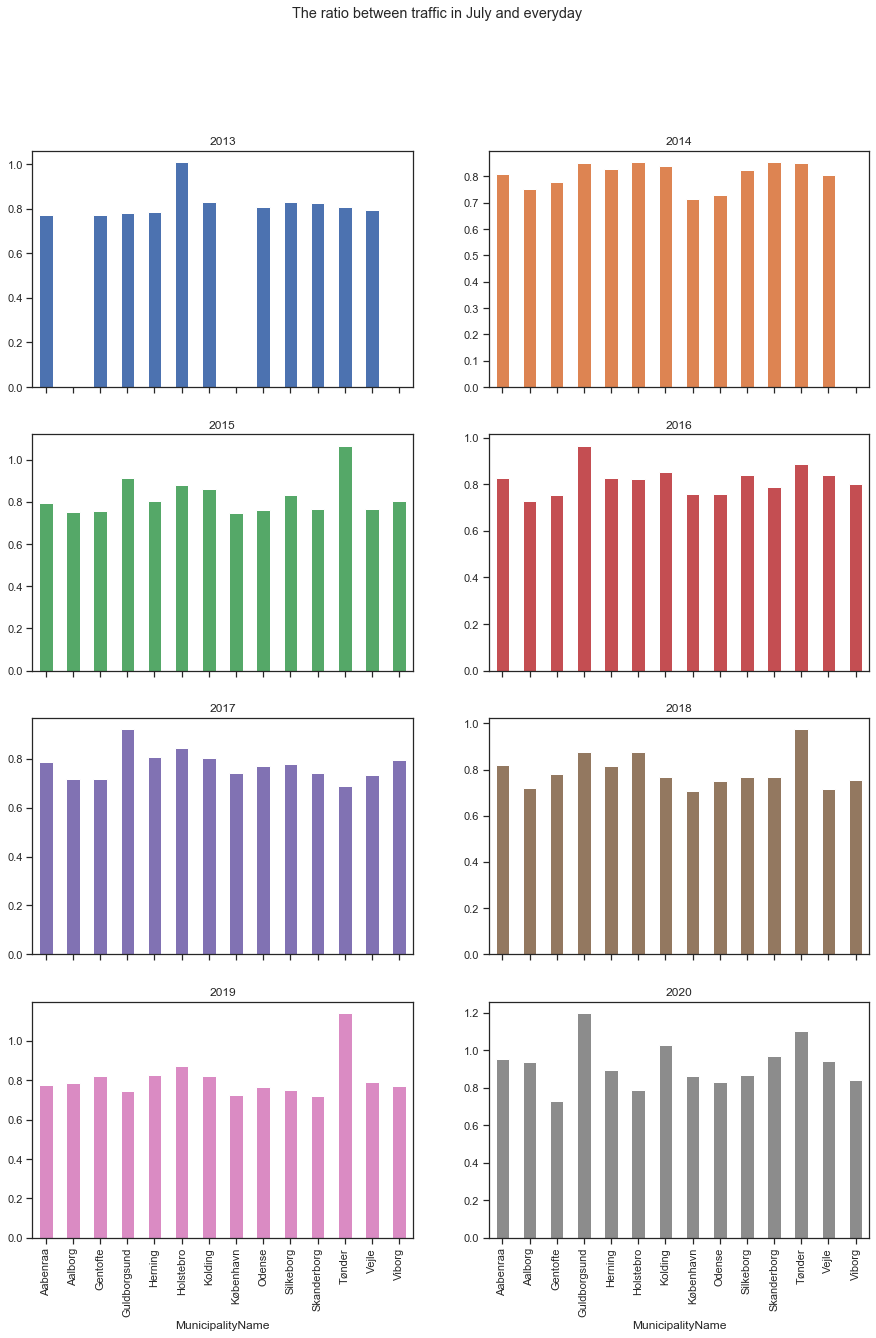

In [69]:
focus_counth =data_to_focus.groupby(['MunicipalityName', 'Year'])['JulyWeekdaysRatio'].mean()
focus_counth.unstack().plot.bar(subplots=True,layout=(4,2), figsize=(15,20), legend=False, title='The ratio between traffic in July and everyday')

Tonder and Koling seem to have an increase!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002525D7FDB38>,
      dtype=object)

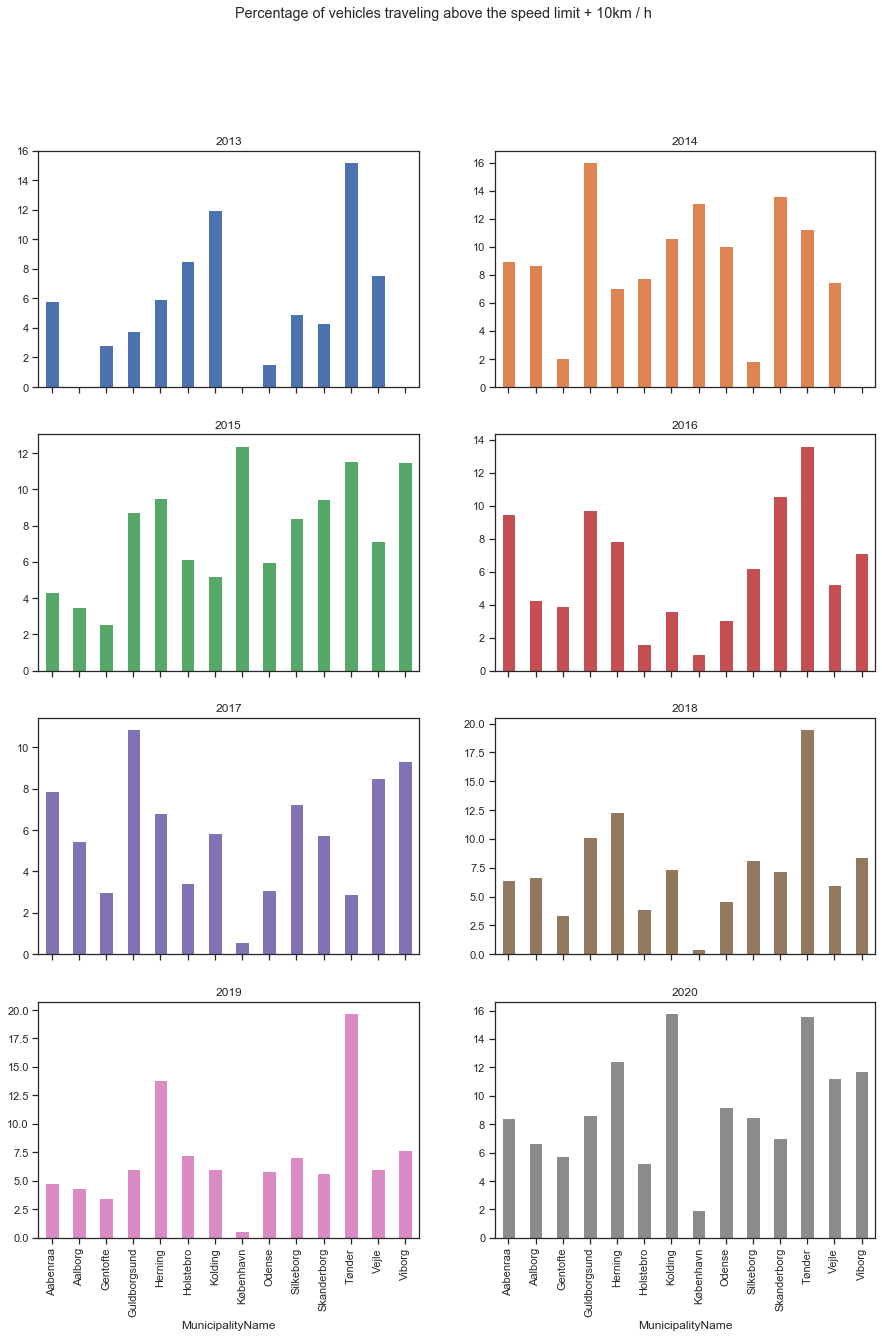

In [70]:
focus_counth =data_to_focus.groupby(['MunicipalityName', 'Year'])['PctOverSpeedLimit10'].mean()
focus_counth.unstack().plot.bar(subplots=True,layout=(4,2), figsize=(15,20), legend=False, title='Percentage of vehicles traveling above the speed limit + 10km / h')

### Plot focusmunicipaliy variables

In [71]:
data_to_focus = data_to_focus.reset_index(drop=True)

In [72]:
continuous = ['Kilometer', 'Meter',
       'Year', 'AverageDailyVehicles', 'AverageWeekdayDailyVehicles',
       'DailyJulyTraffic', 'AverageSpeed', 'CountedDays',
       'AverageDailyTrucks', 'SpeedLimit', 'Quantile15', 'Quantile85',
       'PctOverSpeedLimit', 'PctOverSpeedLimit10', 'PctOverSpeedLimit20',
       'PctOfTrucks', 'AverageDifferenceSpeedLimitAvgSpeed',
       'JulyWeekdaysRatio']

categories = ['Traffictype','SpeedLimit']

In [73]:
len(continuous)

18

Let's compare the continuous variables for the focus-municipalities.

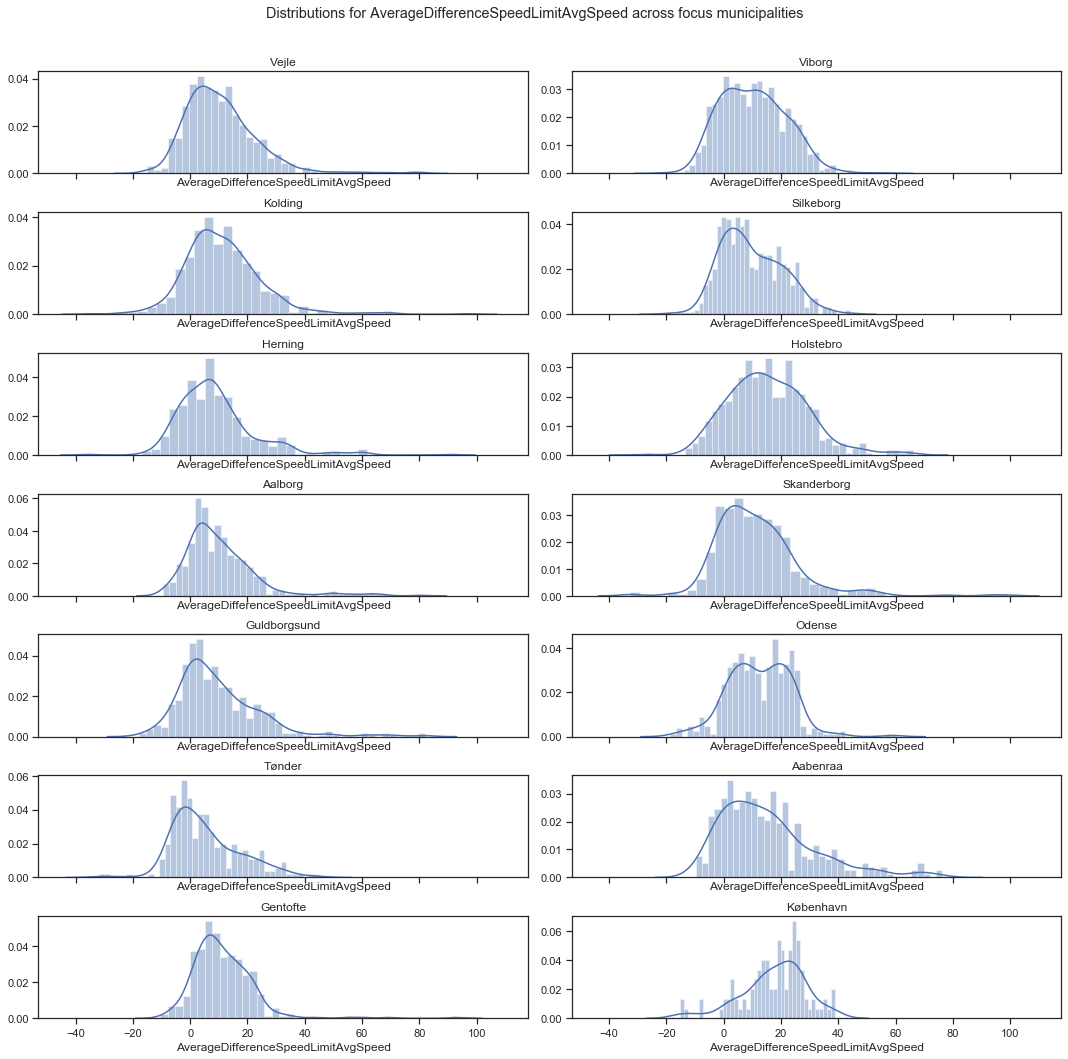

In [74]:
k = 16
f, axes = plt.subplots(7, 2, figsize=(15, 15), sharex=True)
i = 0
for fm in focusmunicipalities:
    sns.distplot((pd.to_numeric(data_to_focus[data_to_focus["MunicipalityName"] == fm][continuous[k]])), ax=axes[i // 2, i % 2], bins = 40).set_title(fm)
    #ax.title(fm)
    f.tight_layout()
    #axes[i // 2, i % 2].set_xlim([0, 20]) # Xlimits for some plots that have very long tails
    i+=1
    
f.subplots_adjust(top=0.92)
f.suptitle('Distributions for {} across focus municipalities'.format(continuous[k]))

f.show()

By changing the value k you can change the variable which is compared.
By choosing k = 6 the Average Speed is plotted for the municipalities. Doing this reveals that København has a much lower average speed compared to places such as Tønder and Viborg.

By choosing the PctOverSpeedLimit20 (k = 14) it is noted that municipalities such as Tønder and Viborg have a large amount of drivers who are driving much faster than the speed limit, compared to for example København and Vejle.

Looking at the previously constructed AverageSpeedToSpeedLimit (k = 16) variable we see that for the majority of the municipalities, the danes are driving slower than the speeding limit, however the speeding limit is exceeded by some drivers. 

In [75]:
# Personal favorites (Jonas) k= 3,6,9,10,11,16

Let's look at the categorical data across the focus municipalities.

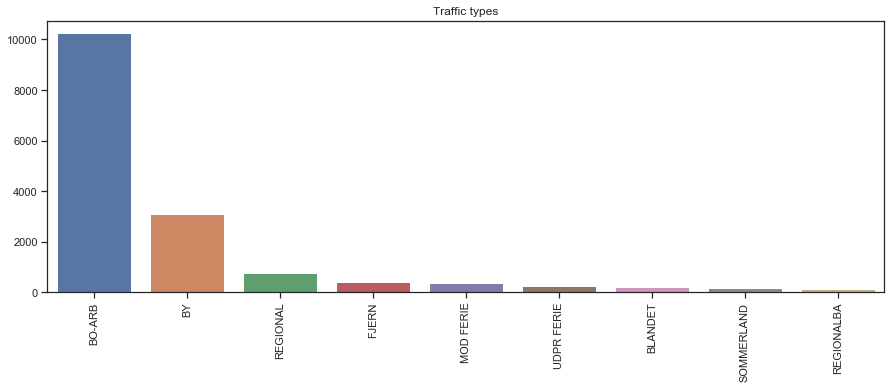

In [76]:
plt.figure(figsize=(15,5))
plt.title("Traffic types")
df = traffic_data.Traffictype.value_counts()
ax = sns.barplot(df.keys(), df.values)
plt.setp(ax.get_xticklabels(), rotation=90);

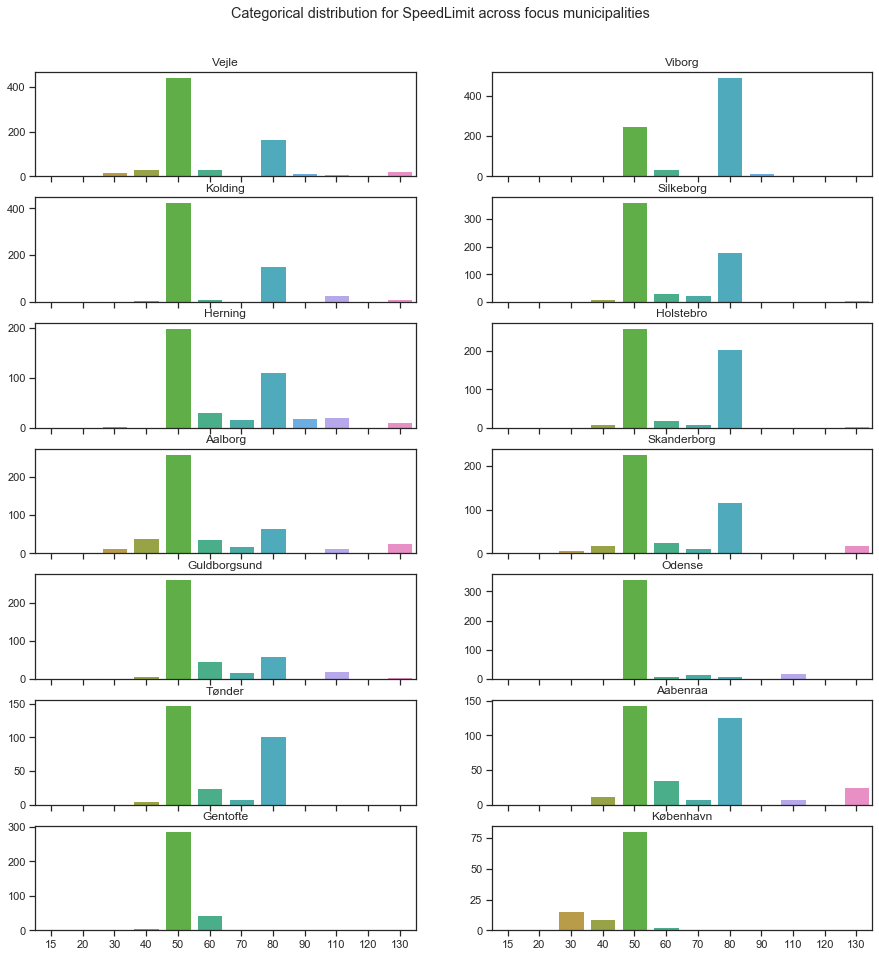

In [77]:
k = 1
f, axes = plt.subplots(7, 2, figsize=(15, 15), sharex=True, sharey = False)
i = 0 


for fm in focusmunicipalities:
    vals = []
    possiblespeeds = data_to_focus[categories[k]].value_counts().keys()
    
    df = data_to_focus[data_to_focus["MunicipalityName"] == fm][categories[k]]
    
    for j in range(len(possiblespeeds)):
        vals.append(sum(df == possiblespeeds[j]))
    
    sns.barplot(possiblespeeds.astype(np.int), vals, ax = axes[i // 2, i % 2]).set_title(fm)
    #plt.setp(ax.get_xticklabels(), rotation=90);   
    i+=1
    
f.subplots_adjust(top=0.92)
f.suptitle('Categorical distribution for {} across focus municipalities'.format(categories[k]))
f.show()

Looking at the SpeedLimit variable it is noticed that 50 is the most common speed limit across the roads in the focus municipalities. It is also noted that some municipalities have many high speed roads, while some have almost none. For exampel Gentofte has almost no high speed roads, as this is also a city with no high-way while Aabenraa has a lot more high speed roads.

### KNN-prediction

In [78]:
Xdata = traffic_data[["Longitude","Latitude"]]
Xdata["Latitude"] = Xdata["Latitude"].str.replace(';','')

Xdata = Xdata.astype("float64")
ydata = pd.to_numeric(traffic_data["AverageDifferenceSpeedLimitAvgSpeed"], downcast='float')

In [79]:
knn = KNeighborsRegressor(n_neighbors = 10)
knn.fit(Xdata.values, ydata.values)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [80]:
longrid = np.linspace(7.5018, 12.5018, 100)
latgrid = np.linspace(53.2639 , 57.7639, 100)

In [81]:
preds = knn.predict(Xdata)

In [82]:
colorscale = branca.colormap.linear.RdPu_09.scale(min(preds), max(preds))
colorscale

In [83]:
denmark = folium.Map([56.2639,9.5018], zoom_start=7)


# KNN scatter plot
for i in range(0,len(longrid)):
    for j in range(0,len(latgrid)):
        
        pred = knn.predict([[longrid[i],latgrid[j]]])[0]
        
        folium.CircleMarker(location=[latgrid[j],longrid[i]],
                                radius=0.8,
                                weight=2, color = colorscale(pred)).add_to(denmark)
        
colorscale.caption = 'Average speed to speed limit'
denmark.add_child(colorscale)

In [84]:
'''
denmark2 = folium.Map([56.2639,9.5018], zoom_start=7)


# KNN scatter plot
for i in range(0,len(longrid)):
    for j in range(0,len(latgrid)):
        
        pred = knn.predict([[longrid[i],latgrid[j]]])[0]
        
        folium.Marker(location=[latgrid[j],longrid[i]],
                                color = colorscale(pred)).add_to(denmark2)
        
'''

'\ndenmark2 = folium.Map([56.2639,9.5018], zoom_start=7)\n\n\n# KNN scatter plot\nfor i in range(0,len(longrid)):\n    for j in range(0,len(latgrid)):\n        \n        pred = knn.predict([[longrid[i],latgrid[j]]])[0]\n        \n        folium.Marker(location=[latgrid[j],longrid[i]],\n                                color = colorscale(pred)).add_to(denmark2)\n        \n'

In [85]:
'''
map_1 = denmark2
map_1.save('map_1.html')
import re
import fileinput

with open("map_1.html") as inf:
   txt = inf.read()

#Find all the markers names given by folium
markers = re.findall(r'\bmarker_\w+', txt)
markers = list(set(markers))

for linenum,line in enumerate( fileinput.FileInput("map_1.html",inplace=1) ):
    pattern = markers[0] + ".bindPopup"
    pattern2 = markers[0] + ".on('mouseover', function (e) {this.openPopup();});"
    pattern3 = markers[0] + ".on('mouseout', function (e) {this.closePopup();});"

    if pattern in line:
       print(line.rstrip())
       print(pattern2)
       print(pattern3)
    else:
       print(line.rstrip())
'''

'\nmap_1 = denmark2\nmap_1.save(\'map_1.html\')\nimport re\nimport fileinput\n\nwith open("map_1.html") as inf:\n   txt = inf.read()\n\n#Find all the markers names given by folium\nmarkers = re.findall(r\'\x08marker_\\w+\', txt)\nmarkers = list(set(markers))\n\nfor linenum,line in enumerate( fileinput.FileInput("map_1.html",inplace=1) ):\n    pattern = markers[0] + ".bindPopup"\n    pattern2 = markers[0] + ".on(\'mouseover\', function (e) {this.openPopup();});"\n    pattern3 = markers[0] + ".on(\'mouseout\', function (e) {this.closePopup();});"\n\n    if pattern in line:\n       print(line.rstrip())\n       print(pattern2)\n       print(pattern3)\n    else:\n       print(line.rstrip())\n'